Russell Martin 2021-2024

# Prep 
Imports, define metabolics error, subj cost functions, constriants 

Imports

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, FixedLocator, FuncFormatter
from colour import Color
from cmaes import CMA
import scipy.io as sio 
import math
import scipy
from scipy.interpolate import interp1d
from scipy.stats import spearmanr

import pandas as pd
from IPython.display import display
import pickle5 as pickle
import warnings
import copy
import time as ti

# for saving data
import os
import datetime
import json
import numbers

import time as t
from sklearn.metrics import r2_score
from collections import defaultdict

In [2]:
#Settings
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.family'] = 'sans-serif'  # or 'serif', 'monospace', etc.
matplotlib.rcParams['font.sans-serif'] = ['Myriad Pro']  # List your preferred fonts here
redd = (255/255,36/255,0/255)
def playBeep(): output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

# worksheet = gc.open('BestDurBySubjAndTime_seeded').get_worksheet(0)
def make_dict(): return defaultdict(make_dict)

def Spectrum(totalColorNum, thisColorNum=-1, startColor = "red", endColor = "violet", mute_factor=0.9):

  assert totalColorNum > thisColorNum, "\n\n SPECTRUM() ERROR: thisColorNum exceeds totalColorNum!"

  colors = list(Color(startColor).range_to(Color(endColor),totalColorNum))
  colors = [color.rgb for color in colors]

  colors = [mute_color(rgb, mute_factor) for rgb in colors]
  
  if thisColorNum == -1:
    if totalColorNum == 13:
      colors_colorblind = np.array([
          [216, 27, 96],
          [200, 81, 59],
          [255, 193, 7],
          # [222, 191, 95],
          [174, 192, 140],
          [0, 77, 64],
          [139, 253, 105],
          [87, 201, 187],
          [163, 181, 221],
          [30, 136, 229],
          [20, 114, 137],
          [22, 26, 142],
          [193, 46, 237],
          [159, 87, 167]
      ])
      return (colors_colorblind/255).tolist()
    else:
      return colors
  else:
    return colors[thisColorNum]

import colorsys

def rgb_to_hsl(rgb):
    r, g, b = rgb
    h, l, s = colorsys.rgb_to_hls(r*255, g*255, b*255)
    return h, l, s

def hsl_to_rgb(hsl):
    h, l, s = hsl
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return int(r), int(g), int(b)

def mute_color(rgb, factor=0.9):
    hsl = rgb_to_hsl(rgb)
    muted_s = hsl[1] * factor
    muted_rgb = hsl_to_rgb((hsl[0], muted_s, hsl[2]))
    muted_rgb_01 = tuple(c/255 for c in muted_rgb)
    return muted_rgb_01
  
def plotWithSD(x, y_mean, y_std, color='k', label=None):
  plt.plot(x,y_mean,label=label, color=color, linestyle='solid');
  if np.any(y_std != None):
    plt.fill_between(x, y_mean-y_std, y_mean+y_std, color = color, alpha = 0.3, linewidth=0);

def custom_formatter(x, pos):
    if x.is_integer():  # Check if the number is an integer
        return f'{int(x)}'  # Return as integer
    else:
        return f'{x:.1f}'  # Return with one decimal place



Define metabolics error (data from *Zhang et al. 2017*) using normal distributions

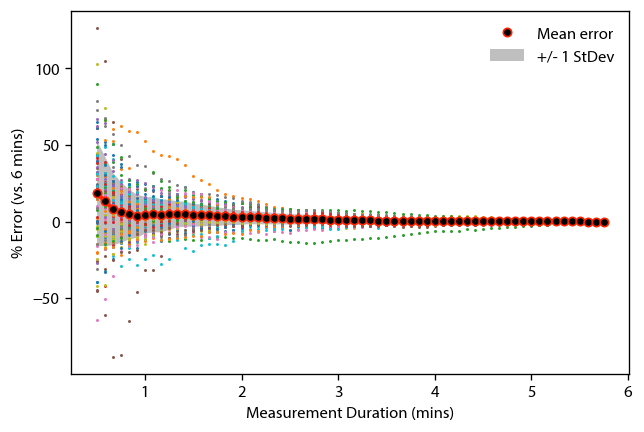

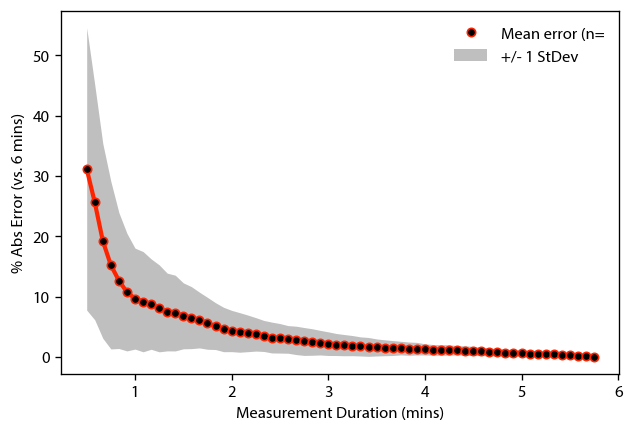

In [3]:
#import data
accuracyData =sio.loadmat('data/zhang2017/Duration,Errors_notAbsVal_allSubjs.mat') #from Zhang et al. 2017
durations = accuracyData["duration"].T / 60 #duration is 64 equal steps from 0.5 min to 5.75 min (5 sec increments)
errors = accuracyData["error"].T       #error = 64 durations x 88 examples. These errors use the true value from the first-order fit steady-state estimate with all 6 mins of data

# dursToTest are the durations of interest in this project (there is no need to test all 64 durations, as very similar results are achieved in similar durations)
dursIdxToTest = [0,3,6,9,12,15,18,21,24,30,36,42,54]
dursToTest = np.array(durations[dursIdxToTest,:]).reshape(-1,1)
nDurs = len(dursToTest)

meanError = np.mean(errors, axis=1) #mean of each measurement duration
sdError = errors.std(1)
meanError_abs = np.mean(np.abs(errors), axis=1)
sdError_abs = np.std(np.abs(errors), axis=1)

# interpolate
durations_interp = np.arange(durations[0][0], durations[-1][0], .01)
meanError_interp = np.interp(durations_interp, np.squeeze(durations), meanError)
sdError_interp = np.interp(durations_interp, np.squeeze(durations), sdError)
meanError_abs_interp = np.interp(durations_interp, np.squeeze(durations), meanError_abs)
sdError_abs_interp = np.interp(durations_interp, np.squeeze(durations), sdError_abs)


### Plot error vs sample duration 
plot = True

if plot:
  fig, ax = plt.subplots()
  ax.plot(durations,errors,'o',markersize=0.8);
  ax.plot(durations,meanError,linewidth=2.5,color=redd);
  ax.plot(durations,meanError,'ko',markersize=5,markeredgecolor=redd,label="Mean error");
  ax.fill_between(np.squeeze(durations), meanError-sdError, meanError+sdError, color='k',alpha = 0.25,linewidth=0.0,label="+/- 1 StDev");
  ax.legend(frameon=False)
  plt.xlabel("Measurement Duration (mins)"), plt.ylabel("% Error (vs. 6 mins)")

  fig, ax = plt.subplots()
  # ax.plot(durations,np.abs(errors),'o',markersize=0.8);
  ax.plot(durations,meanError_abs,linewidth=2.5,color=redd);
  ax.plot(durations,meanError_abs,'ko',markersize=5,markeredgecolor=redd,label="Mean error (n=");
  ax.fill_between(np.squeeze(durations), meanError_abs-sdError_abs, meanError_abs+sdError_abs, color='k',alpha = 0.25,linewidth=0.0,label="+/- 1 StDev");
  ax.legend(frameon=False)
  plt.xlabel("Measurement Duration (mins)"), plt.ylabel("% Abs Error (vs. 6 mins)")


# create normal distribution at each timepoint of error
mu_allDurs = np.zeros(len(errors[:,0]))
std_allDurs = np.zeros(len(errors[:,0]))
for durIdx in range(len(errors[:,0])):
  mu_allDurs[durIdx], std_allDurs[durIdx] = scipy.stats.norm.fit(errors[durIdx,:])

mu_allDurs_interp = np.interp(durations_interp, np.squeeze(durations), mu_allDurs)
std_allDurs_interp = np.interp(durations_interp, np.squeeze(durations), std_allDurs)

In [4]:
def avgMetError(dur): # function to return the average ABSOLUTE error data from a certain duration (in min)
  index = np.squeeze(np.where(np.round(durations,4) == np.round(dur,4))[0])
  if np.size(index) == 0: 
    index = np.squeeze(np.where(np.round(durations_interp,4) == np.round(dur,2))[0])
    return (meanError_abs_interp[index] + 3 )/100 
  else:
    return (meanError_abs[index] + 3 )/100 # add 3 to account for baseline noise

# def sdMetError(dur): # function to return the sd of ABSOLUTE error data from a certain duration (in min)
#   index = np.squeeze(np.where(np.round(durations,4) == np.round(dur,4))[0])
#   if np.size(index) == 0:
#     index = np.squeeze(np.where(np.round(durations_interp,4) == np.round(dur,2))[0])
#     return (sdError_abs_interp[index])/100  
#   else:
#     return (sdError_abs[index])/100  

def sdMetError_signedData(dur=-1): # function to return the sd of the SIGNED error data for a certain duration (min)
  if dur == -1:
    return durations_interp, sdError_interp/100
  index = np.squeeze(np.where(np.round(durations,4) == np.round(dur,4))[0])
  if np.size(index) == 0:
    index = np.squeeze(np.where(np.round(durations_interp,4) == np.round(dur,2))[0])
    return (sdError_interp[index])/100  
  return (sdError[index])/100

### Function to return an error randomly sampled from the skewed normal distribution above
def metError(dur, plot=False):

  addBaselineNoise = True # if true, add 3% noise to all samples to account for the fact that 6-min measurements aren't perfect

  index = np.where(durations == dur)[0]
  if len(index)==0:  #if dur is not in durations, interpolate
    index = np.where(np.round(durations_interp,2) == np.round(dur,2))[0]
    sample = np.random.normal(mu_allDurs_interp[index], std_allDurs_interp[index], 1)
  else:
    index = np.squeeze(index)
    sample = np.random.normal(mu_allDurs[index], std_allDurs[index], 1)
  if addBaselineNoise:
    sample += 3

  if plot==False: 
    return float(sample*.01)  #returns a percent error as a decimal (e.g. +30% error = 0.3)
  

### Generic cost functions and constraints

In [44]:
def getCost_gen(functName, params, sample_time):
  dimensionality = np.size(params)
    
  if "ankle" == functName:
    trueCost = ( 1 +                              # baseline 100% cost
              + 0.95 *( np.exp(-1*params[0])-1)   # torque magnitude term (higher is better) x* = 1
              + 1 * (params[1] - 1) ** 2          # peak torque timing  (later is better) x* = 0.55
              + 0.1 * (params[2] - 0.2) ** 2      # rise time (moderate is best) x* = 0.2
              + 1 * (params[3] - 0) ** 2 )        # fall time (faster is better) x* = 0.1


  elif "nParam" in functName:
              
    # sum cost to get true cost
    tempSum = 0
    if dimensionality > 1:
      for i in range(dimensionality):
        tempSum += (params[i])**2  #params[0]**2 + params[1]**2 + ...
    elif dimensionality == 1:
        tempSum = (params)**2

    trueCost = 1.25/(dimensionality)  *  (tempSum) +  .61

  elif "rosen_nDim" in functName:
    trueCost = rosen_nDim(params)

  elif "levy" in functName:
    trueCost = levy(params)

  # once true cost has been established, add noise
  if sample_time == 0 : #d == 0 represents perfect metabolics accuracy
    return trueCost
  else:
    noisyCost = trueCost * (1+metError(sample_time))
    return noisyCost

### Generic Constraints
def applyConstraints_gen(params, functName):
  
  # project out-of-bounds parameters back into boundary. E.g. if torque is 1.2, make it 1
  if functName == "ankle":    
    # peak torque between 0-1
    params[0] = np.amax((np.amin((params[0], 1)), 0))
    # peak torque time between 0.1-0.55
    params[1] = np.amax((np.amin((params[1], 0.55)), 0.1))
    # rise time between 0.1-0.4
    params[2] = np.amax((np.amin((params[2], 0.4)), 0.1))
    # fall time between 0.05-0.2
    params[3] = np.amax((np.amin((params[3], 0.2)), 0.05))

  else:
    n_dim = params.shape[0]

    lim = getInitialConstraints(functName)

    for i in range(n_dim):
      params[i] = min(lim[1],max(lim[0],params[i]))

  return params  

def getAllowableParamRange(functName, n_dim):
  if functName == "ankle":
    paramMins = np.array([0, .1, .1, .05])
    paramMaxes = np.array([1, 0.55, 0.4, 0.2])
  elif functName == "ankle_8param":    
    paramMins = np.array([0, .1, .1, .05, 0, .1, .1, .05])
    paramMaxes = np.array([1, 0.55, 0.4, 0.2, 1, 0.55, 0.4, 0.2])
  else:
    paramMins = np.ones((n_dim)) * -1
    paramMaxes = np.ones((n_dim))

  return np.stack((paramMins, paramMaxes))


def getInitialConstraints(functName, n_dim, maxTime=0):
  if functName == 'rosen_nDim':
    paramMins = np.zeros(n_dim) - 5.12
    paramMaxes = np.zeros(n_dim) + 5.12
  elif functName == 'levy':
    paramMins = np.zeros(n_dim) - 10
    paramMaxes = np.zeros(n_dim) + 10
  elif functName == "ankle":
    paramMins = np.array([0, .1, .1, .05])
    paramMaxes = np.array([1, 0.55, 0.4, 0.2])
  else:
    paramMins = np.zeros(n_dim) - 1
    paramMaxes = np.zeros(n_dim) + 1

  return np.stack((paramMins, paramMaxes))


def scaleParamsToReal(x, functName, maxTime = 0):

  if functName == "VD_peicewise":
    assert maxTime != 0
  
  # format input 
  if type(x) == list:
      x = np.array(x)
  if x.ndim > 1:
      x = np.squeeze(x)
      if x.ndim > 1:
          print('ERROR normalizeParams shape ', np.shape(x))
  
  assert x.all() <= 1
  assert x.all() >= 0
  
  return_x = np.empty(np.shape(x))
  lims = getInitialConstraints(functName, np.shape(x), maxTime)
  param_range = lims[1] - lims[0]
  for i in range(np.size(x)):
    return_x[i] = x[i] * param_range[i] + lims[0][i]
  
  return return_x

def scaleParamsToCMA(x, functName, maxTime = 0):
# this fn scales parameters down so they are bounded to 0-1 

  # format input 
  if type(x) == list:
      x = np.array(x)
  if x.ndim > 1:
      x = np.squeeze(x)
      if x.ndim > 1:
          print('ERROR normalizeParams shape ', np.shape(x))

  lims = getInitialConstraints(functName, np.shape(x), maxTime)
  
  if not (all(x.round(5) <= lims[1]) and all(x.round(5) >= lims[0])):
    print(f'ERROR X NOT WITHIN LIMS SCALEPARAMSTOCMA \n x = {x} lims = {lims}')
  
  return_x = np.empty(np.shape(x))
  param_range = lims[1] - lims[0]
  for i in range(np.size(x)):
    return_x[i] = (x[i] - lims[0][i]) / param_range[i]
  
  return return_x

# Optimization helper functions

In [9]:
# basic helper functions

# scales cost to be between 0 and 1
def minMaxScaler(functName, y, nDims, y0=np.nan):
  minCost = getTrueMinCost(functName, nDims)

  if np.isnan(y0): # scale relative to the initial cost
    return (y - minCost)/(y[0] - minCost)
  else: # scale relative to something else
    return (y - minCost)/(y0 - minCost)


def getTrueMinCost(functName, nDims):
  if functName=="ankle":
    optimal_params = [1, 0.55, 0.2, 0.1]
  elif "nParams" in functName:
    optimal_params = np.zeros(nDims)
  elif 'levy' == functName:
    optimal_params = np.ones(nDims)
  elif functName == 'rosen_nDim':
    optimal_params = np.ones(nDims)
  return getCost_gen(functName, optimal_params, 0)

def isBetween(num, range): # check if a number is within a range (a < x < b). True if within, else False
  returnVal = False
  if (num < range[0] and num > range[1]) or (num > range[0] and num < range[1]):
    returnVal = True
  return returnVal

def pctChange(previous, current, abs = False): # get percent change 
  chg = ((float(current)-previous)/previous)
  if abs: chg = np.abs(chg)
  return chg

def NormalizeData(dataToNormalize, dataForScale): # minmax scale data between 0-1
  return (dataToNormalize - np.nanmin(dataForScale)) / (np.nanmax(dataForScale) - np.nanmin(dataForScale))

def noNans(data):
  mask = ~np.isnan(data)
  # returnArray =  [d[m] for d, m in zip(data.T, mask.T)]
  returnArray = data[mask]
  return returnArray

def saveResults(res, filename='', loc = 'data/sim_results/'):

  if filename == '':
    makeFilename = True
  else:
    makeFilename = False
    filename = loc + filename

  # generate unique filename YYYY MM DD NUM
  if makeFilename:
    counter = 1
    filename = datetime.datetime.now().strftime("%Y-%m-%d")
    filename = loc + filename + " {}.pickle"
    while os.path.isfile(filename.format(counter)):
        # check if this optimization has already been done
        # existing_results = pickle.load( open( filename.format(counter), "rb" ) )
            
        # check if this has already been done
        # if existing_results['opt_params'] == res['opt_params']:
        #     print('File from today with these opt params already exists, not saving!')
        #     saveFile = False
        #     break
        counter += 1

  if makeFilename:
    filename = filename.format(counter)

  # save file
  # save dictionary to pickle file
  with open(filename, 'wb') as file:
      pickle.dump(res, file, protocol=pickle.HIGHEST_PROTOCOL)
  print('\n Saved file as ', filename, '\n\n')

  return filename

### reassess convergence with new metrics

In [28]:
# means_noisy and means_true shape(nExs, nGens, nDurs)
# mean_params shape(nDims, nGens, nExs, nDurs)
# allCondCost_true shape(nExs, nConds, nDurs)
# converged_def contains 'num_prev_mins', 'change_thresh', 'num_prev_gens'
def reassessConvergence(functName, means_noisy, means_true, mean_params, allCondCosts_true, allCondCosts_noisy, converged_def, vd_meanTimepoints, vd_allTimepoints, maxTime):

    # settings
    plot = False
    plotType = 'tn' # 't' for true, 'n' for noisy, 'tn' for both
    debug = False
    startup_time = 60 # mins

    # get optimization specs and convergence definition
    nExs = np.shape(means_noisy)[0]
    nGens = np.shape(means_noisy)[1]
    nVDs = len(vd_meanTimepoints)
    nDurs = np.shape(means_noisy)[2]
    nDims = np.shape(mean_params)[0]
    pop_sz = 4 + math.floor(3 * math.log(nDims))
    num_prev_mins = converged_def['num_prev_mins']
    num_prev_gens = converged_def['num_prev_gens']
    change_thresh = np.abs(converged_def['change_thresh'])
    stop_criteria = converged_def['stop_criteria']
    normalizeByNoisiness = converged_def['normalizeNoisiness']
    useNoisyMeans = converged_def['useNoisyMeans'] # whether convergence looks at noisy or true means
    timeToPct_thresh1 = converged_def['within_x_pct1'] # timeTo will look for how long it takes the true mean cost to get and stay below timeToThresh% of global min
    timeToPct_thresh2 = converged_def['within_x_pct2']
    maxMinParams = getAllowableParamRange(functName, nDims)
    maxParamDist = np.linalg.norm(maxMinParams[1,:] - maxMinParams[0,:])
    timeToPct_thresh1 = getTrueMinCost(functName, nDims) * (1+timeToPct_thresh1)
    timeToPct_thresh2 = getTrueMinCost(functName, nDims) * (1+timeToPct_thresh2)

    # plotting stuff
    pltNum = [2,1,0,3] # example to plot
    if plot:
        if plotType == 'n' or plotType == 't':
            plt.figure(1, figsize=(8,6))
        else:
            plt.figure(1, figsize=(4,6))
        if plotType == 'n': 
            plt.suptitle('n=1 examples of convergence (noisy means) \n ' + str(converged_def))
        elif plotType == 't': 
            plt.suptitle('n=1 examples of convergence (true means) \n ' + str(converged_def))
        plotColors = Spectrum(nDurs-1)
        plotColors.append((0,0,0))
    
    # result arrays, which area all of shape (nExs, nDims) and will contain nan if no convergence
    conv_times = np.nan * np.zeros((nExs, nDurs))
    conv_costs = np.nan * np.zeros((nExs, nDurs))
    conv_to_Xpct1_costs = np.nan * np.zeros((nExs, nDurs))
    conv_to_Xpct2_costs = np.nan * np.zeros((nExs, nDurs))
    entire_costs = np.nan * np.zeros((nExs, nDurs))
    conv_cumul_costs = np.nan * np.zeros((nExs, nDurs))
    postConvCost = np.nan * np.zeros((nExs, nDurs))
    conv_type = np.empty((nExs, nDurs), dtype=np.str_)
    startup_cost = np.nan * np.zeros((nExs, nDurs))
    time_to_Xpct1 = maxTime * np.ones((nExs, nDurs)) # used to be np.nan*np.zeros
    time_to_Xpct2 = maxTime * np.ones((nExs, nDurs))
    rate_to_Xpct1 = np.zeros(nDurs)
    rate_to_Xpct2 = np.zeros(nDurs)
    nearestNeighborCostDifference = {
        'abs': np.nan*np.zeros(np.shape(allCondCosts_true)), # shape(nExs, nConds, nDurs)
        'pct': np.nan*np.zeros(np.shape(allCondCosts_true)), # shape(nExs, nConds, nDurs)
    }
    ranking_accuracy = np.nan*np.zeros((nGens, nExs, nDurs)) # shape(nGens, nExs, nDurs)

    for nDur in range(nDurs):
        
        # determine how far back to look to check convergence
        if nDur < nDurs-nVDs: # if concerning a static vd 
            durIsStatic = True
        else:
            durIsStatic = False
        
        if durIsStatic:
            dur = dursToTest[nDur][0]
            print('\r processing duration = ', dur, '    ', end="")
            # nGens = np.shape(means_noisy[0, :, nDur][means_noisy[0, :, nDur] != 0])[0]
            nGens = np.shape(mean_params[0, :, 0, nDur][mean_params[0, :, 0, nDur] != 0])[0]
            durArray = np.ones((nGens*pop_sz)) * dur
            if num_prev_mins != 0: # if conv definition uses minutes
                numPrevGens_thisDur = int(np.ceil(num_prev_mins / (pop_sz * dur)))
                if num_prev_gens != 0: # if definition also uses generations
                    numPrevGens_thisDur = np.max((numPrevGens_thisDur, num_prev_gens))
            else: 
                numPrevGens_thisDur = num_prev_gens
        else:
            # get duration of each condition
            # a = np.array([vd_meanTimepoints[nDur-(nDurs-nVDs)][0]/pop_sz]) # dur of first generation
            # b = np.diff(vd_meanTimepoints[nDur-(nDurs-nVDs)], n=1)/pop_sz # dur of all other generations
            # c = np.concatenate((a,b)) # dur of each generation (shape(nGens))
            # durArray = np.repeat(c, pop_sz) # dur of each condition (shape(nConds))
            
            print('\r processing duration = VD ', nDur-(nDurs-nVDs),  '    ', end="")
            

        for nEx in range(nExs):

            if not durIsStatic:
                vdTimepoints = vd_allTimepoints[nDur-(nDurs-nVDs)]
                if len(vdTimepoints) == nExs:
                    vdTimepoints = vdTimepoints[nEx]
                vdTimepoints = np.append(np.array([0]), vdTimepoints) # prepend with 0
                durArray = np.diff(vdTimepoints, n=1)
                
            # get mean costs and params this example that were actually tested (nonzero)
            noisyMeanCosts = means_noisy[nEx, :, nDur][means_noisy[nEx, :, nDur] != 0]        # shape(nGens)
            params_thisEx = mean_params[:, :, nEx, nDur] # shape(nDims, nGens)
            done = False
            trueMeanCosts = means_true[nEx, :, nDur]
            trueMeanCosts = trueMeanCosts[trueMeanCosts != 0]
            # allCondCosts_true_thisEx = allCondCosts_true[nEx, :, nDur][allCondCosts_true[nEx, :, nDur] != 0] 
            allCondCosts_true_thisEx = allCondCosts_true[nEx, :np.size(durArray), nDur]
            allMeasurementTimes = np.cumsum(durArray)

            # startup_cost and time_to_Xpct are easy to calculate
            startup_cost[nEx, nDur] = np.sum(allCondCosts_true_thisEx[allMeasurementTimes < startup_time] * durArray[allMeasurementTimes < startup_time])
            entire_costs[nEx, nDur] = np.sum(allCondCosts_true_thisEx * durArray)

            # START calculation of time_to_Xpct1, rate_to_Xpct1
            for i in range(2):
                if i == 0:
                    timeToPct_thresh = timeToPct_thresh1
                elif i == 1:
                    timeToPct_thresh = timeToPct_thresh2
                
                all_idxs_above_thresh =  [i for i,v in enumerate(trueMeanCosts) if v > timeToPct_thresh]
                if len(all_idxs_above_thresh) == 0:
                    all_idxs_above_thresh = [0]
                idx_below_thresh = (np.max(all_idxs_above_thresh)+1) * pop_sz - 1 #index of first condition s.t. all means after are within x% of minima
                if idx_below_thresh < np.size(allMeasurementTimes)-1: # if thresh achieved before final measurement
                    xpct_time = allMeasurementTimes[idx_below_thresh] # time which below xpct is acheived

                    if xpct_time < 1 * allMeasurementTimes[-1]: # this always evaluates to true - previously we this 1 was 0.9 to ensure convergence happened with adequate time remaining to ensure it's actually convergence
                        if i == 0:
                            time_to_Xpct1[nEx, nDur] = xpct_time
                            conv_to_Xpct1_costs[nEx, nDur] = np.sum(allCondCosts_true[nEx, :idx_below_thresh, nDur] * durArray[:idx_below_thresh])
                            rate_to_Xpct1[nDur] += 1
                        elif i == 1:
                            time_to_Xpct2[nEx, nDur] = xpct_time
                            conv_to_Xpct2_costs[nEx, nDur] = np.sum(allCondCosts_true[nEx, :idx_below_thresh, nDur] * durArray[:idx_below_thresh])
                            rate_to_Xpct2[nDur] += 1
                else: # if thresh not achieved, set time/cost to xpct as maxtime
                    if i == 0:
                        time_to_Xpct1[nEx, nDur] = allMeasurementTimes[-1]
                        conv_to_Xpct1_costs[nEx, nDur] = np.sum(allCondCosts_true[nEx, :idx_below_thresh+1, nDur] * durArray[:])
                    elif i == 1:
                        time_to_Xpct2[nEx, nDur] = allMeasurementTimes[-1]
                        conv_to_Xpct2_costs[nEx, nDur] = np.sum(allCondCosts_true[nEx, :idx_below_thresh+1, nDur] * durArray[:])

            # END calculation of time_to_Xpct1 and 2

            # START calculation of nearestNeighborCostDifference
            for nGen in range(np.size(noisyMeanCosts)): # for each generation
                if nGen == 0:
                    # dursThisGen = durs[0:pop_sz-1]
                    costsThisGen = allCondCosts_true[nEx, 0:pop_sz-1, nDur]
                else:
                    # dursThisGen = durs[nGen*pop_sz-1:(nGen+1)*pop_sz-1]
                    costsThisGen = allCondCosts_true[nEx, nGen*pop_sz-1:(nGen+1)*pop_sz-1, nDur]
                    
                for c in range(len(costsThisGen)): # for every candidate
                    nCond = nGen*pop_sz + c
                    # find candidate's nearest costing neighbor (excluding itself)
                    costDifferences = abs((costsThisGen[c] - costsThisGen))
                    NNcost = np.min(np.delete(costDifferences, c))
                    NNidx = np.argwhere(costDifferences == NNcost)[0,0]
                    nearestNeighborCostDifference['abs'][nEx, nCond, nDur] = np.abs(costDifferences[NNidx])
                    nearestNeighborCostDifference['pct'][nEx, nCond, nDur] = np.abs(costDifferences[NNidx]/costsThisGen[c])

            # START calculation of conv_times, conv_costs, conv_type
            for nGen in range(np.size(noisyMeanCosts)): # for each generation

                if not durIsStatic: # if VD, get numPrevGens
                    if num_prev_mins == 0:
                        numPrevGens_thisDur = num_prev_gens
                    else:
                        starting_gen = np.argmax(vd_meanTimepoints > (vd_meanTimepoints[nGen] - num_prev_mins))-1 # figure out starting gen based on num_prev_mins
                        numPrevGens_thisDur = np.max((nGen - starting_gen, num_prev_gens)) # if num_prev_gens is also specified, do the larger of num_prev_gens or num_prev_mins


                if nGen > numPrevGens_thisDur:

                    # check if cost has stabilized
                    if 'c' in stop_criteria: 
                        stabilized_cost = True
                        for n in range(numPrevGens_thisDur):

                            # convergence can be based on the true or noisy costs
                            if useNoisyMeans:
                                thisGen_cst = noisyMeanCosts[nGen - n]
                                lastGen_cst = noisyMeanCosts[nGen - n - 1]
                            else:
                                thisGen_cst = trueMeanCosts[nGen - n]
                                lastGen_cst = trueMeanCosts[nGen - n - 1]
                                
                            # optionally, can take expected noisiness into account when considering convergence of noisy means
                            if normalizeByNoisiness and useNoisyMeans:
                                thisDur = durArray[(nGen)*pop_sz]
                                lastDur = durArray[(nGen - 1)*pop_sz]
                                thisGen_range = [thisGen_cst * (1 + avgMetError(thisDur)), thisGen_cst * (1 - avgMetError(thisDur))]
                                lastGen_range = [lastGen_cst * (1 + avgMetError(lastDur)), lastGen_cst * (1 - avgMetError(lastDur))]

                                # three criteria, if any of which are satisfied, we're still stable
                                overlappingRange = (isBetween(thisGen_range[0], lastGen_range) or isBetween(thisGen_range[1], lastGen_range))
                                pctChangeBounds = (pctChange(lastGen_range[1], thisGen_range[0], abs=True) < change_thresh or pctChange(lastGen_range[0], thisGen_range[1], abs=True) < change_thresh)
                                pctChangeMeasurement = pctChange(lastGen_cst, thisGen_cst, abs=True) < change_thresh

                                if debug and nDur == nDurs-1:
                                    print('nEx ', nEx, ', dur ', thisDur, ', nGen ', nGen, ', nPrev', n, ', thisGen_cst [range] ', thisGen_cst, thisGen_range, 
                                        'lastGen_cst [range] ', lastGen_cst, lastGen_range)
                                    print('\t overlappingRange ', overlappingRange, ', pctChangeBounds ', 
                                    pctChangeBounds, '(', pctChange(lastGen_range[1], thisGen_range[0], abs=True), ',', pctChange(lastGen_range[0], thisGen_range[1], abs=True),')',
                                    ', pctChangeMeasurement', pctChangeMeasurement, '(',pctChange(lastGen_cst, thisGen_cst),')')

                                if not (overlappingRange or pctChangeBounds or pctChangeMeasurement):
                                    if debug: print('NO CONV')
                                    stabilized_cost = False
                                    break

                            # convergence definition that just looks at change in mean cost without considering noise
                            else:                                
                                if np.abs(pctChange(lastGen_cst, thisGen_cst)) > change_thresh:
                                    stabilized_cost = False
                                    break
                            

                    else: 
                        stabilized_cost = False
                    
                    # check if params have stabilized
                    if 'p' in stop_criteria: 
                        stabilized_params = True
                        for n in range(numPrevGens_thisDur):
                            thisGen_par = params_thisEx[:, nGen - n]
                            lastGen_par = params_thisEx[:, nGen - n - 1]
                            chg_par = np.linalg.norm(thisGen_par - lastGen_par) / maxParamDist # normalized change in parameters 
                            if (chg_par > change_thresh):
                                stabilized_params = False
                                break
                    else:
                        stabilized_params = False

                    # if we've found convergence
                    if stabilized_cost or stabilized_params:
                        if debug: print('CONVERGENCE')
                        done = True

                        conv_times[nEx, nDur] = np.sum(durArray[:(nGen+1)*pop_sz])
                        conv_costs[nEx, nDur] = trueMeanCosts[nGen]
                        conv_cumul_costs[nEx, nDur] = np.sum(allCondCosts_true[nEx, :nGen*pop_sz, nDur] * durArray[:nGen*pop_sz])
                        postConvCost[nEx, nDur] = np.mean( allCondCosts_true[nEx, nGen+1:, nDur][allCondCosts_true[nEx, nGen+1:, nDur] != 0] )

                        if stabilized_cost:
                            conv_type[nEx, nDur] = 'c'
                            shape = 'o'
                        elif stabilized_params:
                            conv_type[nEx,  nDur] = 'p'
                            shape = 's'

                    # if at the end and still no convergence
                    elif nGen == np.size(noisyMeanCosts)-1:
                        conv_type[nEx, nDur] = 't'
                        done = True
                        shape = 'x'

                    if done:
                        if plot and nEx == pltNum[0] and plotType == 'tn': # only plot one example, true and noisy means
                            
                            times = np.cumsum(durArray)[pop_sz-1::pop_sz] # shape(nGens)

                            for i in range(2):
                                if i == 0:
                                    plotCosts = trueMeanCosts
                                    plt.title('true mean costs')
                                elif i == 1:
                                    plotCosts = noisyMeanCosts
                                    plt.title('noisy mean costs')
                                plt.subplot(2,1,i+1)
                                
                                plt.plot(times[:nGen+1], plotCosts[:nGen+1], color=plotColors[nDur], zorder=nDur, marker = 'o', ms = 2)
                                plt.scatter(times[nGen], plotCosts[nGen], color=plotColors[nDur], marker=shape, zorder=nDur)
                                plt.plot(times[nGen:], plotCosts[nGen:], color=plotColors[nDur], alpha=0.6, zorder=nDur-nDurs, linestyle='--')
                            
                        elif plot and nEx in pltNum and plotType != 'tn': # plot many examples, true or noisy means
                            plt.subplot(2,2,nEx+1)
                            
                            times = np.cumsum(durArray)[pop_sz-1::pop_sz] # shape(nGens)

                            if plotType == 't':
                                plotCosts = trueMeanCosts
                            elif plotType == 'n':
                                plotCosts = noisyMeanCosts
                            
                            plt.plot(times[:nGen+1], plotCosts[:nGen+1], color=plotColors[nDur], zorder=nDur, marker = 'o', ms = 2)
                            plt.scatter(times[nGen], plotCosts[nGen], color=plotColors[nDur], marker=shape, zorder=nDur)
                            plt.plot(times[nGen:], plotCosts[nGen:], color=plotColors[nDur], alpha=0.6, zorder=nDur-nDurs, linestyle='--')
                        break
            # END calculation of conv_times, conv_costs, conv_type

            # START calculation of ranking_accuracy
            for nGen in range(np.size(noisyMeanCosts)):
                true_costs = allCondCosts_true[nEx, nGen*pop_sz:(nGen+1)*pop_sz, nDur]
                noisy_costs = allCondCosts_noisy[nEx, nGen*pop_sz:(nGen+1)*pop_sz, nDur]
                ranking_accuracy[nGen, nEx, nDur], _ = spearmanr(true_costs, noisy_costs) # shape(nGens, nExs, nDurs)
                

    rate_to_Xpct1 /= nExs
    rate_to_Xpct2 /= nExs
    # pack results
    results = {}
    results['converge_times'] = conv_times.tolist()
    results['converge_costs'] = conv_costs.tolist()
    results['entire_costs'] = entire_costs.tolist()
    results['converge_cumul_costs'] = conv_cumul_costs.tolist()
    results['postConv_cost'] = postConvCost.tolist()
    results['converge_type'] = conv_type.tolist()
    results['startup_cost'] = startup_cost.tolist()
    results['time_to_Xpct1'] = time_to_Xpct1.tolist()
    results['time_to_Xpct2'] = time_to_Xpct2.tolist()
    results['rate_to_Xpct1'] = rate_to_Xpct1.tolist()
    results['rate_to_Xpct2'] = rate_to_Xpct2.tolist()
    results['conv_to_Xpct1_costs'] = conv_to_Xpct1_costs.tolist()
    results['conv_to_Xpct2_costs'] = conv_to_Xpct2_costs.tolist()
    results['nearest_neighbor_cost_difference_abs'] = nearestNeighborCostDifference['abs']
    results['nearest_neighbor_cost_difference_pct'] = nearestNeighborCostDifference['pct']
    results['ranking_accuracy'] = ranking_accuracy
    
    return results

### AS-CMA

In [11]:
from scipy.spatial import distance

# spacing-dependent variable duration 
# params is shape(nConds, nDims) and are normalized [0,1] to param space
# covMat is shape(nDim,nDim) and used for calculating mahalanobis distance
# slope_info contains the previous generation's 'costPerDist' and 'avgCost'
def calcDurations(params, functName, beta=0, slope_info=np.nan):

    nConds = np.shape(params)[0]
    nDims = np.shape(params)[1]
    maxMinParams = np.stack((np.ones((nDims)), np.zeros((nDims)))) 
    minMaxCost = getExpectedMinMaxCost(functName)
    returnDurations = np.zeros(nConds) * np.nan

    if type(slope_info) is dict: # this will evaluate to true after generation 1
        changing_slope = True 
    else:
        changing_slope = False

    maxParamDist = np.linalg.norm(maxMinParams[1,:] - maxMinParams[0,:]) # possibly /sqrt(nDims)
    
    # calcualte the distance from each condition to each other condition
    dist_table = np.zeros((nConds, nConds)) * np.nan
    for i in range(nConds):
        for j in range(nConds):
            dist_table[i,j] = np.linalg.norm(params[i,:] - params[j,:])

    dist_table /= maxParamDist
    
    avgExpectedCost = np.average(minMaxCost)
    rangeExpectedCost = np.abs(minMaxCost[1] - minMaxCost[0])
    distOfClosestCondition_all = np.zeros((nConds))
    idxOfClosestCondition_all = np.zeros((nConds))

    for i in range(nConds):
        # for each condition, calculate the dist of the closest other condition 
        distOfClosestCondition_all[i] = np.min(np.delete(dist_table[i,:], i))
        idxOfClosestCondition_all[i] = (np.argwhere(dist_table[i,:] == distOfClosestCondition_all[i]))[0]

    for i in np.argsort(distOfClosestCondition_all):
        distOfClosestCondition = distOfClosestCondition_all[i]

        # knowing the distance away from eachother, calculate the expected costs
        if changing_slope: 
            expectCosts = [slope_info['avgCost'] - (distOfClosestCondition / 2) * slope_info['costPerDist'],
                        slope_info['avgCost'] + (distOfClosestCondition / 2) * slope_info['costPerDist']]
        else:
            expectCosts = [avgExpectedCost - (distOfClosestCondition / 2) * (rangeExpectedCost / (maxParamDist/2)), 
                        avgExpectedCost + (distOfClosestCondition / 2) * (rangeExpectedCost    / (maxParamDist/2)) ]
            slope_info = {}
            slope_info['avgCost'] = avgExpectedCost # aka "y_avg"
            slope_info['costPerDist'] = rangeExpectedCost / (maxParamDist/2) # aka "k_avg"

        # knowing the expected costs, calculate the min duration that gives us enough signal to noise
        #    to make a determination about which condition costs more
        durations_int, sdErrors = sdMetError_signedData()       # shape(n_possible_durations,) [pct]
        k_avg = slope_info['costPerDist']
        y_avg = slope_info['avgCost']
        d_in = distOfClosestCondition

        y_avg = np.mean(expectCosts)
        epsilon_desired = k_avg * d_in/(np.sqrt(2) * y_avg * beta)
        closest_duration_idx_to_desired = np.argmin(np.abs(sdErrors - epsilon_desired))

        # print(shortest_duration_idx_satisfying_beta, closest_duration_idx_to_desired)
        returnDurations[i] = np.squeeze(durations_int)[closest_duration_idx_to_desired]

    return returnDurations

def getExpectedMinMaxCost(functName):
    # return AS-CMA \hat{y}_{min} and \hat{y}_{max}

    returnVal = np.nan 
    if functName == 'ankle':
        returnVal = np.array([0.6, 1.3])
    elif 'nParams' in functName: # n-D bowl
        returnVal = np.array([0.6, 1.3])
    elif 'rosen' in functName:
        returnVal = np.array([0,10000])
    elif 'levy' in functName:
        returnVal = np.array([0, 250])

    return returnVal

def linearRegressFixZeroIntercept(x, m):
    b = 0
    y = m*x+b
    return y

def getAvgSlopePerDistance(params, costs):
    nDims = np.shape(params)[1]
    nConds = np.shape(params)[0]
    costs = np.squeeze(costs)

    maxMinParams = np.stack((np.ones((nDims)), np.zeros((nDims)))) 
    maxParamDist = np.linalg.norm(maxMinParams[1,:] - maxMinParams[0,:]) # possibly /sqrt(nDims)

    dist_table = np.zeros((nConds, nConds)) * np.nan
    cost_table = np.zeros((nConds, nConds)) * np.nan
    runningCostPerDist = []
    returnInfo = {}

    for i in range(nConds):
        for j in range(nConds):
            dist_table[i,j] = np.linalg.norm(params[i,:] - params[j,:]) / maxParamDist
            cost_table[i,j] = np.abs(costs[i] - costs[j])
            if cost_table[i,j] != 0:
                runningCostPerDist.append(cost_table[i,j] / dist_table[i,j])
    m, pcov = scipy.optimize.curve_fit(linearRegressFixZeroIntercept, dist_table.flatten(), cost_table.flatten()) 
    returnInfo['costPerDist'] = m[0]
    returnInfo['costPerDist_SD'] = np.sqrt(np.diag(pcov))[0]
    returnInfo['avgCost'] = np.average(costs)
        
    return returnInfo

def getSortingPrecision(noisy, true):    
    actualResults = np.argsort(noisy).flatten()
    trueResults = np.argsort(true).flatten()
    nResults = len(actualResults)

    x = np.zeros(nResults)
    y = np.zeros(nResults)
    for i in range(nResults):
        x[i] = i
        y[i] = np.argwhere(actualResults == trueResults[i])
    r = scipy.stats.pearsonr(x,y)[0]
    
    return r

### Standard functions

In [12]:
def rosen_nDim(x): # from https://docs.scipy.org/doc/scipy-0.14.0/reference/tutorial/optimize.html#unconstrained-minimization-of-multivariate-scalar-functions-minimize
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0) + 100

def levy(xx):

    # format input 
    if type(xx) == list:
        xx = np.array(xx)
    if xx.ndim > 1:
        xx = np.squeeze(xx)
        assert xx.ndim == 1, 'ERROR levy xx shape '+str(np.shape(x))
    
    d = len(xx)
    w = np.zeros(d)

    for ii in range(d):
        w[ii] = 1 + (xx[ii] - 1)/4

    term1 = 10+(np.sin(np.pi*w[0]))**2
    term3 = (w[d-1]-1)**2 * (1+(np.sin(2*np.pi*w[d-1]))**2)

    term2 = 0
    for ii in range(d-1):
        wi = w[ii]
        new = (wi-1)**2 * (1+10*(np.sin(np.pi*wi+1))**2)
        term2 += new

    y = term1 + term2 + term3
    
    return y


# CMA-ES

In [22]:
def cmaOptimization_gen(n_dim, functName, nExamples, dursToTest, optimization_time, vdABC, elit_means = [0,1], min_dist_scale = 0, conductStaticDurs = True, sigma=0.75): #_gen indicates generic function
  import time as ti
  totalCalcDurTime = 0

  population_size = 4 + math.floor(3 * math.log(n_dim)) # pop_size = 8 when n_dim = 4
  maxGens = int(np.ceil(optimization_time/(0.5 * population_size)))  # max gens is dependent on shortest condition (30 sec)
  sig = sigma # initial sigma
  sig_vd = sigma # initial sigma
  nDurs = len(dursToTest)
  nVDs = 1 # placeholder in case more than one AS-CMA variant is tested 
  cma_lims = np.tile(np.array([0,1]), (n_dim,1))

  # STORAGE VARIABLES FOR RETURN TO MAIN FCN
  params = np.zeros((n_dim,maxGens*population_size,nExamples,nDurs+nVDs))
  values_noisy = np.zeros((nExamples, maxGens * population_size, nDurs+nVDs))
  values_true = np.zeros((nExamples, maxGens * population_size, nDurs+nVDs))
  sigmas = np.zeros((nExamples, maxGens, nDurs+nVDs))
  mean_costs = [None] * (nDurs + nVDs) # # mean_costs is a list of length (nDurs+nVDs), each item in list is a np array of shape (nExamples, nGens) containing the mean value of each examples generation

  startt = ti.time()
  np.random.seed(3) # for repeatable results

  # make nExamples sets of initial mean parameters
  # "ankle" fn has the same initial parameters every time
  if functName == "ankle" or functName == "ankle_interaction":
    initParams = scaleParamsToCMA(np.array([0.5, 0.45, 0.25, 0.15]), functName)
  elif functName == "ankle_8param":
    initParams = scaleParamsToCMA(np.array([0.5, 0.45, 0.25, 0.15, 0.5, 0.45, 0.25, 0.15]), functName)
  # other functions have a random starting point, but each starting point in each run is the same across sampling strategy
  else: 
    if functName == 'rosen_nDim':
      if n_dim > 2:
        initRange = [-5.12, 5.12]
      else:
        initRange = [-2, 2]
    elif functName == "levy":
      initRange = [-10, 10]
    else: #nParams (bowl)
      initRange = [-1,1]
    initParams = np.random.uniform(initRange[0],initRange[1],nExamples).reshape((-1,1))
    for i in range(n_dim-1):
      nextParam = np.random.uniform(initRange[0],initRange[1],nExamples).reshape((-1,1))
      initParams = np.concatenate((initParams,nextParam),axis=1)
  
  """
  Static sample time CMA-ES
  """
  if conductStaticDurs:
    
    for nDur in range(nDurs):
      mean_costs_thisDur = np.zeros((nExamples, maxGens)) * np.NaN
      
      for ex in range(nExamples):

        t=0 # time tracking for bowl shift test

        if functName == "ankle":
          initialization = initParams
          initialization = initParams[:]+1E-10  #need to add tiny value to initParams so initParams doesn't get changed on optimizer.tell()
        else:
          initialization = initParams[ex,:]+1E-10  #need to add tiny value to initParams so initParams doesn't get changed on optimizer.tell()
          initialization = scaleParamsToCMA(initialization,functName)

        optimizer = CMA(mean=initialization, sigma=sig, seed=ex, bounds=cma_lims, n_max_resampling=0) # note that if candidate is outside of bounds in CMA.ask, candidate is resampled

        dur = dursToTest[nDur]

        for generation in range(maxGens):

          #for storing params and values
          valsThisGen_noisy = np.zeros((1,population_size))
          valsThisGen_true = np.zeros((1,population_size))
          paramsThisGen = np.zeros((n_dim,population_size))
          solutions = []

          #'condLim' stores number of conds to do per gen, factoring in use of elitism and means
          condLim = population_size
          if elit_means[0] == True and generation != 0: # elitism
            condLim -= 1
          if elit_means[1] == True: # means
            condLim -= 1

          # choose parameter sets to be tested this generation; _01 indicates normalized between [0,1]
          condsToTest_01 = np.empty((population_size, n_dim))
          for i in range(condLim): 
            condsToTest_01[i, :] = optimizer.ask()                              # (1) random parameters sampled from cma
          if elit_means[0] == True and generation != 0: # elitism
            i += 1
            condsToTest_01[i, :] = scaleParamsToCMA(eliteParams, functName)  # (2) 2nd to last param to test is elite params
          if elit_means[1] == True: # means
            i += 1
            condsToTest_01[i, :] = np.clip(optimizer._mean, 0, 1)            # (3) final param to test is this generation's mean params

          for cond in range(condLim):  #for each generation
            
            selectedParams_01 = condsToTest_01[cond, :] 

            if min_dist_scale > 0 and cond > 0:
              selectedParams_01 = checkParamDistances(selectedParams_01, paramsThisGen, optimizer._sigma, 
                                                  cond, functName, n_dim, min_dist_scale)

            selectedParams = scaleParamsToReal(selectedParams_01, functName)

            value_noisy = getCost_gen(functName, selectedParams, dur)
            value_true = getCost_gen(functName, selectedParams, 0)
            solutions.append((selectedParams_01, value_noisy))

            #save cost evaluations and params from each condition
            valsThisGen_noisy[0,cond] = value_noisy
            values_noisy[ex, generation * population_size + cond, nDur] = value_noisy
            values_true[ex, generation * population_size + cond, nDur] = value_true
            params[:, generation * population_size + cond, ex, nDur] = selectedParams # # n_dim,nGens*population_size,nExamples,nDurs
            # valsThisGen_true[0,cond] = value_true
            paramsThisGen[:,cond]=selectedParams
            # params[:,generation*population_size+cond,ex,nDur]=np.array(selectedParams) 

            t = t + dur

            # print('dur=', dur, 'gen=', generation, 'cond=', cond, 'params01=', selectedParams_01, 'params=', selectedParams, 'trueCost=', value_true, 
            # 'noisyCost=', value_noisy, 'mean=', optimizer._mean, 'sig=', optimizer._sigma)

          #after each gen
          if any(elit_means):

            # (1) test ELITE condition from last gen if not on first gen
            if elit_means[0] and generation != 0:
              cond += 1
              eliteParams_01 = condsToTest_01[-2, :] 
              eliteParams = scaleParamsToReal(eliteParams_01, functName)
              value_noisy = getCost_gen(functName,eliteParams, dur)
              value_true = getCost_gen(functName,eliteParams, 0)
              values_noisy[ex, generation * population_size + cond, nDur] = value_noisy
              values_true[ex, generation * population_size + cond, nDur] = value_true
              params[:, generation * population_size + cond, ex, nDur] = eliteParams 
              solutions.append((eliteParams_01, value_noisy))
              t = t + dur

              #save results
              valsThisGen_noisy[0,cond]=value_noisy
              # valsThisGen_true[0,cond]=value_true
              paramsThisGen[:,cond]=eliteParams
              # params[:,generation*population_size+cond,ex,nDur]=np.array(eliteParams)

            # (2) test MEANS for current gen
            if elit_means[1]:
              cond += 1
              meanParams_01 = condsToTest_01[-1, :] 
              meanParams = scaleParamsToReal(meanParams_01, functName)
              value_noisy = getCost_gen(functName,meanParams, dur)
              value_true = getCost_gen(functName,meanParams, 0)
              values_noisy[ex, generation * population_size + cond, nDur] = value_noisy
              values_true[ex, generation * population_size + cond, nDur] = value_true
              params[:, generation * population_size + cond, ex, nDur] = meanParams
              solutions.append((meanParams_01, value_noisy))
              t = t + dur

              #save results
              valsThisGen_noisy[0,cond]=value_noisy
              paramsThisGen[:,cond]=meanParams
              
            
            # (3) save elite condition from current gen
            eliteParams = paramsThisGen[:,np.argmin(valsThisGen_noisy)]

          # save once-per-generation things
          sigmas[ex, generation, nDur] = optimizer._sigma
          meanParams = scaleParamsToReal(optimizer._mean, functName)
          mean_costs_thisDur[ex, generation] = getCost_gen(functName,meanParams, 0) 

          optimizer.tell(solutions)

          # this ends optimization
          if t>=optimization_time:
            break
      
        pctComplete = 100*((nDur * nExamples) + ex + 1) / (nDurs * nExamples)
        pctComplete_str = str(round(pctComplete,1))
        elapsedTime = (ti.time() - startt)/60 # mins
        totalTimeEst = elapsedTime / (pctComplete/100)
        eta = totalTimeEst - elapsedTime
        eta_str = str(round(eta,1))
        print('\r Function ', functName,": ", pctComplete_str,'% Complete. ETA for this function: ',eta_str, 'mins', end="")  
      mean_costs[nDur] = mean_costs_thisDur

  """
  AS-CMA Optimization 
  """

  print('\n')
  startt = ti.time()
  time_forPlot_byVD = []
  
  if not conductStaticDurs:
    nDur = nDurs-1

  for nVD in range(nVDs):
    time_forPlot = []
    mean_costs_thisDur = np.zeros((nExamples, maxGens))

    nDur += 1

    beta = 1.3 # 1.3 default

    for ex in range(nExamples):

      if functName == "ankle":
        initialization = initParams
        initialization = initParams[:]+1E-10  #need to add tiny value to initParams so initParams doesn't get changed on optimizer.tell()
      else:
        initialization = initParams[ex,:]+1E-10  #need to add tiny value to initParams so initParams doesn't get changed on optimizer.tell()
        initialization = scaleParamsToCMA(initialization,functName)

      optimizer = CMA(mean=initialization, sigma=sig_vd, seed=ex, bounds=cma_lims, n_max_resampling=0)
      t = 0

      tThisEx = []
      generation = 0
      done = False
      slopeInfo = None

      while not done:
        solutions = []

        valsThisGen_noisy = np.zeros((1,population_size))
        valsThisGen_true = np.zeros((1,population_size))
        paramsThisGen = np.zeros((n_dim,population_size))

        #'condLim' stores number of conds to do per gen, factoring in use of elitism and means
        condLim = population_size
        if elit_means[0] == True and generation != 0: # elitism
          condLim -= 1
        if elit_means[1] == True: # means
          condLim -= 1

        # choose parameter sets to be tested this generation; _01 indicates normalized between [0,1]
        condsToTest_01 = np.empty((population_size, n_dim))
        for i in range(condLim): 
          condsToTest_01[i, :] = optimizer.ask()                              # (1) random parameters sampled from cma
        if elit_means[0] == True and generation != 0: # elitism
          i += 1
          condsToTest_01[i, :] = scaleParamsToCMA(eliteParams, functName)  # (2) 2nd to last param to test is elite params
        if elit_means[1] == True: # means
          i += 1
          condsToTest_01[i, :] = optimizer._mean                             # (3) final param to test is this generation's mean params
          
        t0 = ti.time()
        if generation != 0 and slopeInfo != None:
          thisGenerationDurations = calcDurations(condsToTest_01, functName, beta=beta, slope_info=slopeInfo)
        else:
          thisGenerationDurations = calcDurations(condsToTest_01, functName, beta=beta)
        totalCalcDurTime += ti.time() - t0
          
        for cond in range(condLim):  #for each condition
          selectedParams_01 = condsToTest_01[cond]

          dur = thisGenerationDurations[cond]
                    
          selectedParams = scaleParamsToReal(selectedParams_01, functName)
          value_noisy = getCost_gen(functName, selectedParams, dur)
          value_true = getCost_gen(functName, selectedParams, 0)
          solutions.append((selectedParams_01, value_noisy))

          #save cost evaluations and params from each condition
          valsThisGen_noisy[0,cond]=value_noisy 
          valsThisGen_true[0,cond] = value_true
          paramsThisGen[:,cond]=selectedParams     

          values_noisy[ex, generation * population_size + cond, nDur] = value_noisy
          values_true[ex, generation * population_size + cond, nDur] = value_true
          params[:, generation * population_size + cond, ex, nDur] = selectedParams

          t = t + dur 
          tThisEx.append(t)

        #after each gen
        if any(elit_means):

          # (1) test ELITE condition from last gen 
          if elit_means[0] and generation != 0:
            cond += 1
            dur = thisGenerationDurations[cond]
            eliteParams_01 = condsToTest_01[-2]
            eliteParams = scaleParamsToReal(eliteParams_01, functName)
            value_noisy = getCost_gen(functName,eliteParams, dur)
            value_true = getCost_gen(functName,eliteParams, 0)
            values_noisy[ex, generation * population_size + cond, nDur] = value_noisy
            values_true[ex, generation * population_size + cond, nDur] = value_true
            params[:, generation * population_size + cond, ex, nDur] = eliteParams
            solutions.append((eliteParams_01, value_noisy))
            t = t + dur
            tThisEx.append(t)

            #save results
            valsThisGen_noisy[0,cond]=value_noisy
            valsThisGen_true[0,cond] = value_true
            paramsThisGen[:,cond]=eliteParams

          # (2) test MEANS for current gen
          if elit_means[1]:
            cond += 1
            dur = thisGenerationDurations[cond]
            meanParams_01 = condsToTest_01[-1]
            meanParams = scaleParamsToReal(meanParams_01, functName)
            value_noisy = getCost_gen(functName,meanParams, dur)
            value_true = getCost_gen(functName,meanParams, 0)
            solutions.append((meanParams_01, value_noisy))
            t = t + dur
            tThisEx.append(t)

            #save results from means
            valsThisGen_noisy[0,cond]=value_noisy
            valsThisGen_true[0,cond] = value_true
            paramsThisGen[:,cond]=meanParams

            values_noisy[ex, generation * population_size + cond, nDur] = value_noisy
            values_true[ex, generation * population_size + cond, nDur] = value_true
            params[:, generation * population_size + cond, ex, nDur] = meanParams
          
          # (3) save elite condition from current gen
          eliteParams = paramsThisGen[:,np.argmin(np.squeeze(valsThisGen_noisy))]

        # save once-per-generation things
        meanParams = scaleParamsToReal(optimizer._mean, functName)
        mean_costs_thisDur[ex, generation] = getCost_gen(functName,meanParams, 0) 
        
        sigmas[ex, generation, nDur] = optimizer._sigma
        optimizer.tell(solutions) 
        
        if not np.all(valsThisGen_noisy == valsThisGen_noisy[0][0]): # if not all the same cost measured, get slope
          slopeInfo = getAvgSlopePerDistance(condsToTest_01, valsThisGen_noisy)            

        if t>=optimization_time:
          done = True # done optimizing, so break
        else: # if still optimizing
          generation += 1

      #save time vs val plot for each ex
      time_forPlot.append(np.array(tThisEx).reshape(-1)) # for this adaptive sampling approach
      
      pctComplete = nVD/(nVDs) + ((ex+1)/nExamples)/nVDs
      estTotalTime = (ti.time() - startt)/pctComplete
      eta = (estTotalTime - (ti.time() - startt)) / 60
      print(f'VD {nVD+1} of {nVDs}. Overall progress on VD tests: {100*pctComplete:.1f} pct, eta {eta:.1f} mins', end='\r') 

    # save time vs val plot for each vd
    time_forPlot_byVD.append(time_forPlot) # for all adaptive sampling runs
    mean_costs[nDurs + nVD] = mean_costs_thisDur

  mean_costs = np.stack(mean_costs) # (nDurs+nVDs, nExs, nGens)
  mean_costs = np.transpose(mean_costs, axes=[1, 2, 0])  #shape(nExs, nGens, nDurs)

  # return sigmas, values_noisy, params, np.squeeze(sigmas_allExs_vd), values_noisy_allExs_vd, params_allExs_vd, time_forPlot
  results = {
    'sigmas' : sigmas.tolist(),
    'values_noisy' : values_noisy.tolist(), 
    'values_true' : values_true.tolist(), 
    'params' : params.tolist(), 
    'timepoints_vd' : time_forPlot_byVD,
    'means': mean_costs
  }

  return results 

# **Conduct Optimization Runs**

Run everything above this cell to prepare for testing/plotting

In [23]:
def optimize(functName, n_dim, nExamples, optimization_time, vd_curve, sigma=0.3):

  rawOptResults = cmaOptimization_gen(n_dim, functName, nExamples, dursToTest, 
                                      optimization_time,  vd_curve, 
                                      elit_means = [0,1], conductStaticDurs = True, sigma=sigma)

  # save data
  opt_params = {  
      'nExamples' : nExamples, 
      'n_dim' : n_dim,
      'functName' : functName,
      'optimization_time' : optimization_time,
      'vd_curve' : vd_curve.tolist(),
      'nVDs' : len(rawOptResults['timepoints_vd']),
      'sigma' : sigma
    }
  res = {
    'opt_params': opt_params, 
    'rawOptResults' : rawOptResults
  }

  if nExamples > 3: 
    saveFileName = saveResults(res)
  else:
    saveFileName = '(file not saved)'

  return res, saveFileName


nExs = 5
optTime = 500
fn = 'rosen_nDim' # 'ankle', 'rosen_nDim', 'levy', 'nParams20'
dimensions = 4 # 4 for ankle/rosen/levy, 20 for nParams20

res, saveFileName = optimize(fn, dimensions, nExs, optTime, vd_curve = np.array([]), sigma=0.3)  

  

 Function  rosen_nDim :  100.0 % Complete. ETA for this function:  0.0 mins

VD 1 of 1. Overall progress on VD tests: 100.0 pct, eta 0.0 mins
 Saved file as  data/sim_results/2025-06-02 2.pickle 




# Assess and plot results

### Process optimization results

In [ ]:
def evalute_optimization_results(filename): 
    converged_def = {
        'num_prev_mins' : 0,
        'num_prev_gens' : 3,
        'change_thresh' : 0.05,        
        'stop_criteria' : 'c',  # c (cost), p (params), or cp
        'normalizeNoisiness' : True,
        'within_x_pct1': 0.05,
        'within_x_pct2': 0.20,
        'useNoisyMeans': True
    }

    loc = 'data\sim_results\\'

    # see if file has been loaded, if so, then don't spend time re-loading it
    filename = filename + '.pickle'
    print('loading ', loc+filename, '...')
    results = pickle.load( open( loc+filename, "rb" ) )
    print(loc+filename, ' loaded')
    print(results['opt_params'])

    # unpack optimization parameters
    nExamples = results['opt_params']['nExamples']
    n_dim = results['opt_params']['n_dim']
    functName = results['opt_params']['functName']
    optimization_time = int(results['opt_params']['optimization_time'])
    pop_size = 4 + math.floor(3 * math.log(n_dim))
    if 'converged_def' in results:
        converged_def_orig = results['opt_params']['converged_def']
    else:
        converged_def_orig = None

    # unpack optimization data that doesn't involve convergence 
    rawOptResults = results['rawOptResults']
    values_true = np.array(rawOptResults['values_true']) # shape(nExs, nConds, nDurs)
    values_noisy = np.array(rawOptResults['values_noisy']) # shape(nExs, nConds, nDurs)
    params = np.array(rawOptResults['params']) # shape(nDims, nConds, nExs, nDurs)
    means_true = results['rawOptResults']['means'] # shape(nExs, nGens, nDurs+nVDs)
    means_noisy = copy.deepcopy(values_noisy[:, pop_size-1::pop_size, :]) # shape(nExs, nGens, nDurs)
    sigmas = np.array(rawOptResults['sigmas']) # shape()

    nVDs = np.shape(means_true)[2] - np.shape(dursToTest)[0]
    nStaticDurs = np.shape(dursToTest)[0]

    # if we're redefining convergence, reassess convergence and update 
    meanParams = params[:, pop_size-1::pop_size, :, :]
    meanTimepoints_vd = [[] for x in range(nVDs)]
    allTimepoints_vd =  [[] for x in range(nVDs)]
    for i in range(nVDs):
        for j in range(nExamples):
            meanTimepoints_vd[i].append(rawOptResults['timepoints_vd'][i][j][pop_size-1::pop_size])
            allTimepoints_vd[i].append(rawOptResults['timepoints_vd'][i][j])

    newResults = reassessConvergence(functName, means_noisy, means_true, meanParams, values_true, values_noisy, converged_def, meanTimepoints_vd, allTimepoints_vd, optimization_time)

    #unpack new results
    rawOptResults['converge_times'] = newResults['converge_times']
    rawOptResults['converge_costs'] = newResults['converge_costs']
    rawOptResults['entire_costs'] = newResults['entire_costs']
    rawOptResults['converge_cumul_costs'] = newResults['converge_cumul_costs']
    rawOptResults['postConv_cost'] = newResults['postConv_cost']
    rawOptResults['converge_type'] = newResults['converge_type']
    rawOptResults['startup_cost'] = newResults['startup_cost']
    rawOptResults['time_to_Xpct1'] = newResults['time_to_Xpct1']
    rawOptResults['time_to_Xpct2'] = newResults['time_to_Xpct2']
    rawOptResults['rate_to_Xpct1'] = newResults['rate_to_Xpct1']
    rawOptResults['rate_to_Xpct2'] = newResults['rate_to_Xpct2']
    rawOptResults['conv_to_Xpct1_costs'] = newResults['conv_to_Xpct1_costs']
    rawOptResults['conv_to_Xpct2_costs'] = newResults['conv_to_Xpct2_costs']
    rawOptResults['ranking_accuracy'] = newResults['ranking_accuracy']

    #unpack data that involves convergence point
    entire_costs = np.array(rawOptResults['entire_costs'])
    startupCost = np.array(rawOptResults['startup_cost'])
    time_to_Xpct1 = np.array(rawOptResults['time_to_Xpct1'])
    time_to_Xpct2 = np.array(rawOptResults['time_to_Xpct2'])
    rate_to_Xpct1 = np.array(rawOptResults['rate_to_Xpct1'])
    rate_to_Xpct2 = np.array(rawOptResults['rate_to_Xpct2'])
    cost_to_Xpct1 = np.array(rawOptResults['conv_to_Xpct1_costs'])
    cost_to_Xpct2 = np.array(rawOptResults['conv_to_Xpct2_costs'])

    ### save analyzed data for re-plotting
    processedResults = {
        'opt_params' : results['opt_params'],               # nExamples, n_dim, functName, optimization_time, 
        'dursToTest' : dursToTest,
        'nVDs' : nVDs,
        'nStaticDurs' : nStaticDurs,

        'means_true' : means_true, 				                # shape(nExs, nGens, nDurs)
        'values_true_avg' : np.mean(values_true, axis=0),	    # shape(nConds, nDurs)
        'params_avg' : np.mean(params, axis=2),			        # shape(nDims, nConds, nDurs)
        'sigmas_avg' : np.mean(sigmas, axis=0),			        # shape(nExs, nGens, nDurs)

        'timepoints_vd' : rawOptResults['timepoints_vd'],       # list[nVDs][nEx][nConds]

        'entire_costs' : entire_costs,				            # shape(nExs, nDurs)
        'startup_cost' : startupCost,				            # shape(nExs, nDurs)
        'time_to_Xpct1' : time_to_Xpct1,			            # shape(nExs, nDurs)
        'time_to_Xpct2' : time_to_Xpct2,			            # shape(nExs, nDurs)
        'rate_to_Xpct1' : rate_to_Xpct1,			            # shape(nExs, nDurs)
        'rate_to_Xpct2' : rate_to_Xpct2,			            # shape(nExs, nDurs)	
        'cost_to_Xpct1' : cost_to_Xpct1,		                # shape(nExs, nDurs)
        'cost_to_Xpct2' : cost_to_Xpct2,		                # shape(nExs, nDurs)
        'converged_def' : converged_def,                        # ['within_x_pct1', 'within_x_pct2']
        'ranking_accuracy': rawOptResults['ranking_accuracy']   #shape(nGens, nExs, nDurs)
    }
    saveResults(processedResults, filename = (filename[:-7] + ' analysis.pickle'))
        
# run mainPlot to save a '_analysis' file 

filesToSave = ['2025-06-02 2'] 
for i in range(len(filesToSave)):
    evalute_optimization_results(filesToSave[i])

loading  data\sim_results\2025-06-02 2.pickle ...
data\sim_results\2025-06-02 2.pickle  loaded
{'nExamples': 5, 'n_dim': 4, 'functName': 'rosen_nDim', 'optimization_time': 500, 'vd_curve': [], 'nVDs': 1, 'sigma': 0.3}
Convergence being redefined. Original =  None  New =  {'num_prev_mins': 0, 'num_prev_gens': 3, 'change_thresh': 0.05, 'stop_criteria': 'c', 'normalizeNoisiness': True, 'within_x_pct1': 0.05, 'within_x_pct2': 0.2, 'useNoisyMeans': True}
 processing duration = VD  0     Plotting...

 Saved file as  data/sim_results/2025-06-02 2 analysis.pickle 




<Figure size 1800x900 with 0 Axes>

### Multi-run plot

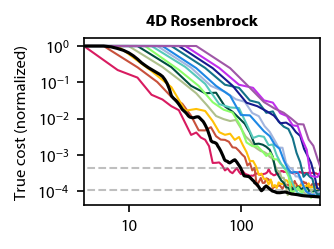

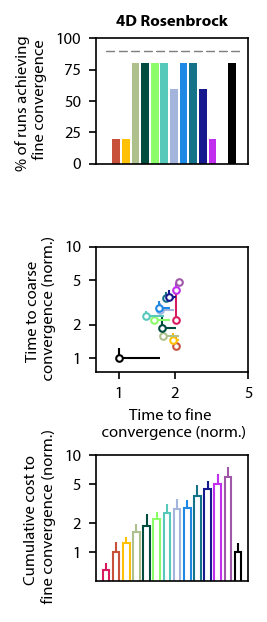

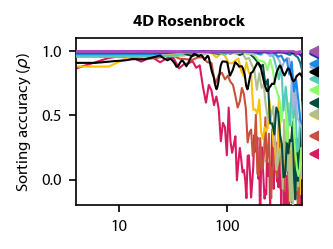

In [40]:
def plotMultiRun(files):

	# settings
	saveAsPDF = False
	plotStaticDurs = True
	minmaxscale = True
	CONVERG_RATE_THRESH = 0.9

	figSaveLoc = 'figs/'

	#
	plots = {
        '1': 1, # PAPER avg true cost of each gen mean +/- sd [line] (prev plot 2)
		'7': 1, # PAPER combined rate/time/cost to convergence 
		'9': 1,	# PAPER ranking accuracy over optimization
    }

	niceFunctNames = {
		'ankle' : '4D Ankle',
		'nParams20' : '20D Sphere',
		'levy' : '4D Levy',
		'rosen_nDim' : '4D Rosenbrock'
		
	}

	# declare variables 
	nRuns = len(files)
	res = [None] * nRuns
	opt_params = [None] * nRuns
	functName = [None] * nRuns
	dursToTest = [None] * nRuns
	nDims = [None] * nRuns
	pop_size = [None] * nRuns
	nVDs = [None] * nRuns
	nStaticDurs = [None] * nRuns
	nDurs = [None] * nRuns
	nExs = [None] * nRuns
	means_true = [None] * nRuns
	values_true_avg = [None] * nRuns
	params_avg = [None] * nRuns
	sigmas_avg = [None] * nRuns
	timepoints_vd = [None] * nRuns
	entire_costs = [None] * nRuns
	startup_cost = [None] * nRuns
	time_to_Xpct1 = [None] * nRuns
	time_to_Xpct2 = [None] * nRuns
	rate_to_Xpct1 = [None] * nRuns
	rate_to_Xpct2 = [None] * nRuns
	cost_to_Xpct1 = [None] * nRuns
	cost_to_Xpct2 = [None] * nRuns
	converged_def = [None] * nRuns
	ranking_accuracy = [None] * nRuns

	# read in data
	for nRun in range(nRuns):
		# load and unpack data
		loc = 'data\\sim_results\\'
		
		res[nRun] = pickle.load(open(loc + files[nRun] + ' analysis.pickle', "rb"))
		opt_params[nRun] = res[nRun]['opt_params']						# nExamples, n_dim, functName, optimization_time, 
		functName[nRun] = opt_params[nRun]['functName']					# str
		dursToTest[nRun] = res[nRun]['dursToTest']						# int
		nVDs[nRun] = res[nRun]['nVDs']									# int
		nStaticDurs[nRun] = res[nRun]['nStaticDurs']					# int 
		nDurs[nRun] = nVDs[nRun] + nStaticDurs[nRun]					# int
		means_true[nRun] = res[nRun]['means_true']						# shape(nExs, nGens, nDurs)
		nExs[nRun] = np.shape(means_true[nRun])[0]
		values_true_avg[nRun] = res[nRun]['values_true_avg']			# shape(nConds, nDurs)
		params_avg[nRun] = res[nRun]['params_avg']						# shape(nDims, nConds, nDurs)
		nDims[nRun] = np.shape(params_avg[nRun])[0]						# int
		pop_size[nRun] = 4 + math.floor(3 * math.log(nDims[nRun]))		# int
		sigmas_avg[nRun] = res[nRun]['sigmas_avg']						# shape(nExs, nGens, nDurs)
		timepoints_vd[nRun] = res[nRun]['timepoints_vd']				# list[nVDs][nEx][nConds]
		entire_costs[nRun] = res[nRun]['entire_costs']					# shape(nExs, nDurs)
		startup_cost[nRun] = res[nRun]['startup_cost']					# shape(nExs, nDurs)
		time_to_Xpct1[nRun] = res[nRun]['time_to_Xpct1']				# shape(nExs, nDurs)
		time_to_Xpct2[nRun] = res[nRun]['time_to_Xpct2']				# shape(nExs, nDurs)
		rate_to_Xpct1[nRun] = res[nRun]['rate_to_Xpct1']				# shape(nDurs)
		rate_to_Xpct2[nRun] = res[nRun]['rate_to_Xpct2']				# shape(nDurs)
		cost_to_Xpct1[nRun] = res[nRun]['cost_to_Xpct1']				# shape(nExs, nDurs)
		cost_to_Xpct2[nRun] = res[nRun]['cost_to_Xpct2']				# shape(nExs, nDurs)
		converged_def[nRun] = res[nRun]['converged_def']
		ranking_accuracy[nRun] = res[nRun]['ranking_accuracy']			# shape(nGens, nExs, nDurs)

	assert len(set(nVDs)) == 1, 'ERROR different run setups'
	assert len(set(nStaticDurs)) == 1, 'ERROR different run setups'

	# general plotting setup: get plot colors, names
	plotColors = Spectrum(nDurs[0]-nVDs[0], mute_factor=0.85) 
	if 0: # set to 1 unless plots['10'] is true
		VDcolors = [(0,0,0), (0.25, 0.25, 0.25), (0.5, 0.5, 0.5), (0.75, 0.75, 0.75)]
	else:
		VDcolors = Spectrum(nVDs[0], mute_factor=0.0)
	dursToTestString = [str(x) for x in np.squeeze(dursToTest[0])]
	VDnames = ['Adaptive Sampling', '2', '3', '4', '5', '6', '7']
	for i in range(nVDs[0]):
		plotColors.append((VDcolors[i]))
		dursToTestString.append(VDnames[i])
	nDursToPlot = list(range(nDurs[0]))
	
	# create figure specs
	axisLabelFontSz = 8
	axisTickFontSz = 8
	subTitleFontSz = 8
	scale = 1 
	nCols = int(np.min([nRuns,2]))
	nRows = int(np.ceil(nRuns / nCols))
	figWidth_in = 2.1
	figHeight_in = 1.8
	figPad = .25
	figLineWidth = 1
	figMarkerSize = 10
	fig_height_scale = 0.85

	# figure: avg true cost of each gen mean 
	if plots['1']:
		plt.figure(figsize=(figWidth_in*nCols*scale,figHeight_in*nRows*scale*fig_height_scale), dpi=150)
		
		for r in range(nRuns):
			plt.subplot(nRows, nCols, r+1)
			minCost = getTrueMinCost(functName[r], nDims[r])

			threshold_ys = (np.array([converged_def[r]['within_x_pct1'], converged_def[r]['within_x_pct2']]) + 1) * minCost
			if minmaxscale:
				avg_initial_mean_cost = np.average(means_true[r][:, 0, :])

			for nDur in range(nDurs[r]):
				if nDur < nDurs[r]-nVDs[r] and plotStaticDurs:
					dur = dursToTest[r][nDur][0]
					y_orig = np.nanmean(means_true[r],axis=0)[:,nDur]
					y = y_orig[y_orig != 0]
					y = np.insert(y, 0, y[0])
					ystd = np.nanstd(means_true[r], axis=0)[:,nDur] # /np.sqrt(nExs)
					ystd = ystd[y_orig != 0]
					ystd = np.insert(ystd, 0, ystd[0])
					x = dur * pop_size[r] * np.arange(1,np.size(y))
					x = np.insert(x,0, 0)
				elif nDur >= nDurs[r]-nVDs[r]: 
					optimization_time = opt_params[r]['optimization_time']
					x = np.linspace(0, optimization_time, optimization_time)
					y = np.zeros((nExs[r], np.size(x)))
					for nEx in range(nExs[r]):
						x_orig = timepoints_vd[r][nDur-(nDurs[r]-nVDs[r])][nEx][pop_size[r]-1::pop_size[r]]
						y_orig = means_true[r][nEx, :, nDur]
						y_orig = y_orig[y_orig != 0]
						y[nEx,:] = np.interp(x, x_orig, y_orig)
						# ystd = np.nanstd(means_true, axis=0)[:,nDur] # /np.sqrt(nExs)
						# ystd = ystd[y_orig != 0]
					ystd = np.std(y, axis=0)
					y = np.mean(y, axis=0)

				if minmaxscale: 
					y = minMaxScaler(functName[r], y, nDims[r], avg_initial_mean_cost)
					threshold_ys = minMaxScaler(functName[r], threshold_ys, nDims[r], avg_initial_mean_cost)
					
				if (nDur < nDurs[r]-nVDs[r] and plotStaticDurs) or (nDur >= nDurs[r]-nVDs[r]):
					if (nDur >= nDurs[r]-nVDs[r]):
						lw = figLineWidth*1.5
					else: 
						lw = figLineWidth
					plt.plot(x, y, color=plotColors[nDur], label=dursToTestString[nDur], zorder = nDur, linewidth=lw)
					plt.plot(np.array([x[0], x[-1]]), np.array([threshold_ys[0],threshold_ys[0]]), color=[0.5,0.5,0.5], alpha=0.5, linestyle='--', linewidth=figLineWidth)
					plt.plot(np.array([x[0], x[-1]]), np.array([threshold_ys[1],threshold_ys[1]]), color=[0.5,0.5,0.5], alpha=0.5, linestyle='--', linewidth=figLineWidth)
					# if not logScale and not minmaxscale: 
					#     plt.fill_between(x, y-ystd, y+ystd, color = plotColors[nDur], alpha = 0.2,linewidth=0.5);

				# if nDur >= nDurs-nVDs:
				#     break # debug
			# plot housekeeping
			plt.title(niceFunctNames[functName[r]], fontsize=subTitleFontSz, fontweight='bold')
			
			plt.xscale("log")
			plt.yscale("log")
			plt.xlim([4, optimization_time])
			ax = plt.gca()
			ax.tick_params(axis='x', which='minor', bottom=False)
			plt.minorticks_off()
			formatter = ScalarFormatter()
			# formatter.set_scientific(False)  # Disable scientific notation
			# ax.yaxis.set_major_formatter(formatter)
			ax.xaxis.set_major_formatter(formatter)
			ax.xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
			# ax.yaxis.set_major_formatter(FormatStrFormatter("%g"))
			x_tick_positions = [10, 100, 1000]
			ax.xaxis.set_major_locator(FixedLocator(x_tick_positions))     
			y_tick_positions = [0.0001, 0.001, 0.01, 0.1, 1]
			ax.yaxis.set_major_locator(FixedLocator(y_tick_positions))   
			plt.tick_params(axis='both', which='major', labelsize=axisTickFontSz)
			# plt.tick_params(axis='both', which='minor', labelsize=axisTickFontSz)
			
			if r in [0,2]:
				plt.ylabel('True cost (normalized)', fontsize=axisLabelFontSz)
			if r in [2,3]:
				plt.xlabel('Optimization time (mins)', fontsize=axisLabelFontSz)				

		plt.tight_layout(pad=figPad)
		# plt.subplot(nRows, nCols, 2)
		nLabels = len(plt.gca().get_legend_handles_labels()[1])
		ordering = np.arange(nLabels-1).tolist()
		ordering.insert(0, nLabels-1) # move as-cma to front
		# lgd = plt.legend(*([ x[i] for i in ordering ] for x in plt.gca().get_legend_handles_labels()), 
		# 			bbox_to_anchor=(1.0,-.55), loc="center", ncol=nDurs[r], fontsize=axisTickFontSz*.8, 
		# 			title='Sample time (mins)', handlelength=1, title_fontproperties={'size': axisTickFontSz})
		
		if saveAsPDF:
			# plt.savefig(figSaveLoc+'plot1_costVsTime.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')
			plt.savefig(figSaveLoc+'plot1_costVsTime.pdf', bbox_inches='tight')
		
	# figure: combined cost to conv, time to conv, and rate to conv
	if plots['7']:
		nRows_this = 1
		nCols_this = 4
		plt.figure(figsize=(figWidth_in*nCols_this*scale*.6,figHeight_in*nRows_this*scale*2.2), dpi=150)

		# ~~~~~~~~~~~~~~~~~~~~
		# rate to conv
		for r in range(nRuns):
			
			plt.subplot(nRows_this*3,nCols_this,r+1)
			
			counter = 0
			labels = []
			for nDur in nDursToPlot:

				if 1: 
					plt.bar(np.arange(np.max(nDursToPlot)+1), rate_to_Xpct1[r][:]*100, color=plotColors[:], zorder=2)
				plt.hlines(90, 0, np.max(nDursToPlot)+1, color=[0.5,0.5,0.5], alpha=0.5, linestyle=(0, (8,4)), linewidth=figLineWidth*.5, zorder=1)
				
			# plt.tick_params(labelbottom = False, bottom = False)
			plt.title(niceFunctNames[functName[r]], fontsize=subTitleFontSz, fontweight='bold')
			# plt.xticks(range(counter), labels)
			# plt.xticks(fontsize=axisTickFontSz-1, rotation=30, ha='right')
			plt.tick_params(axis='both', which='major', labelsize=axisTickFontSz)
			plt.ylim(0,100)
			ax = plt.gca()
			y_tick_positions = [0, 25, 50, 75, 100]
			ax.yaxis.set_major_locator(FixedLocator(y_tick_positions)) 
			plt.xticks([])
			if r == 0:
				plt.ylabel('% of runs achieving \n fine convergence', fontsize=axisLabelFontSz)
			# if r in [0,1,2,3]:
			# 	plt.xlabel('Duration', fontsize=axisLabelFontSz); 

		# ~~~~~~~~~~~~~~~~~~~~
		# time to conv
		for r in range(nRuns):
			ax = plt.subplot(nRows_this*3,nCols_this,r+4+1)
			scaleToASCMA = True
						
			# only plot a dur if it acheived xpct1 and xpct2 more than a certain rate
			for nDur in range(nDurs[r]):
				if (nDur < nDurs[r]-nVDs[r] and plotStaticDurs) or nDur >= nDurs[r]-nVDs[r]:
					# achiev_rate_xpct1 = 1 - np.count_nonzero(np.isnan(time_to_Xpct1[:, nDur])) / np.size(time_to_Xpct1[:,nDur])
					# achiev_rate_xpct2 = 1 - np.count_nonzero(np.isnan(time_to_Xpct2[:, nDur])) / np.size(time_to_Xpct2[:,nDur])
					achiev_rate_xpct1 = rate_to_Xpct1[r][nDur]
					x = np.nanmean(time_to_Xpct1[r][:, nDur])
					y = np.nanmean(time_to_Xpct2[r][:, nDur])
					xstd = np.nanstd(time_to_Xpct1[r][:, nDur])
					ystd = np.nanstd(time_to_Xpct2[r][:, nDur])
					z = nDur if nDur not in [0+nStaticDurs[r],7+nStaticDurs[r]] else 100
					if scaleToASCMA:
						y /= np.nanmean(time_to_Xpct2[r][:, -1])
						ystd /= np.nanmean(time_to_Xpct2[r][:, -1])
						x /= np.nanmean(time_to_Xpct1[r][:, -1])
						xstd /= np.nanmean(time_to_Xpct1[r][:, -1])
					if achiev_rate_xpct1 >= CONVERG_RATE_THRESH:
						plt.scatter(x, y, color=plotColors[nDur], zorder = z, s=figMarkerSize, linewidth=figLineWidth)
						# plt.errorbar(x,y, xerr = xstd, yerr = ystd, ecolor=plotColors[nDur], fmt = 'none', zorder = z, linewidth=figLineWidth/2)
						plt.errorbar(x,y+ystd/2, yerr = ystd/2, ecolor=plotColors[nDur], fmt = 'none', zorder = z, linewidth=figLineWidth)
						plt.errorbar(x+xstd/2, y, xerr = xstd/2, ecolor=plotColors[nDur], fmt = 'none', zorder = z, linewidth=figLineWidth)


						# print(f'nDur = {nDur}: timeTo5% = {x} +/- {xstd}, timeTo20% = = {y} +/- {ystd}')
					else:
						# plt.errorbar(x,y, xerr = xstd, yerr = ystd, ecolor=plotColors[nDur], fmt = 'none', zorder = z, linewidth=figLineWidth/2)
						
						plt.errorbar(x,y+ystd/2, yerr = ystd/2, ecolor=plotColors[nDur], fmt = 'none', zorder = z, linewidth=figLineWidth)
						plt.errorbar(x+xstd/2, y, xerr = xstd/2, ecolor=plotColors[nDur], fmt = 'none', zorder = z, linewidth=figLineWidth)
						plt.scatter(x, y, edgecolor=plotColors[nDur], facecolor=(1,1,1), zorder = z, s=figMarkerSize, linewidth=figLineWidth)


						# print(nDur, "didn't acheive xpct enough. xpct1 acheived ", np.round(achiev_rate_xpct1,2), "xpct2 acheived ", np.round(achiev_rate_xpct2,2))
			
			# plot housekeeping
			plt.tick_params(axis='both', which='major', labelsize=axisTickFontSz)
			if r == 0:
				plt.ylabel('Time to coarse \n convergence (norm.)', fontsize=axisLabelFontSz)
			if r in [0,1,2,3]:
				plt.xlabel('Time to fine \n convergence (norm.)', fontsize=axisLabelFontSz); 
			if scaleToASCMA:
				if 0: 
					y_min, y_max = ax.get_ylim()  # Get the current y-axis limits
					step = np.ceil((y_max - y_min)/6)
					ticks = np.arange(np.floor(y_min), np.ceil(y_max) + 1, step)
					ticks[-1] = np.ceil(y_max)
					ax.set_yticks(ticks)  # Set y-ticks with step of 1
					plt.ylim((0, np.max(ticks)))
					x_min, x_max = ax.get_xlim()  # Get the current y-axis limits
					step = np.ceil((x_max - x_min)/6)
					ticks = np.arange(np.floor(x_min), np.ceil(x_max) + 1,step)
					ticks[-1] = np.ceil(x_max)
					ax.set_xticks(ticks)  # Set y-ticks with step of 1
					plt.xlim((0, np.max(ticks)))
				else:
					plt.xscale('log')
					plt.yscale('log')
					plt.xlim(left=.75)
					plt.ylim(bottom=.75)
					ax = plt.gca()
					ax.tick_params(axis='x', which='minor', bottom=False)
					plt.minorticks_off()
					formatter = ScalarFormatter()
					# formatter.set_scientific(False)  # Disable scientific notation
					# ax.yaxis.set_major_formatter(formatter)
					ax.xaxis.set_major_formatter(formatter)
					ax.xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
					ax.yaxis.set_major_formatter(FormatStrFormatter("%.0f"))
					x_tick_positions = [.5, 1, 2, 5, 10, 20, 50, 100]
					ax.xaxis.set_major_locator(FixedLocator(x_tick_positions))     
					y_tick_positions = [.5, 1, 2, 5, 10, 20, 50, 100]
					ax.yaxis.set_major_locator(FixedLocator(y_tick_positions))   
					plt.tick_params(axis='both', which='major', labelsize=axisTickFontSz)
					# plt.tick_params(axis='both', which='minor', labelsize=axisTickFontSz)
					y_min, y_max = ax.get_ylim()
					plt.ylim(top = y_tick_positions[np.argwhere(y_tick_positions > y_max)[0][0]])
					x_min, x_max = ax.get_xlim()
					plt.xlim(right = x_tick_positions[np.argwhere(x_tick_positions > x_max)[0][0]])
					
		# ~~~~~~~~~~~~~~~~~~~~
		# combined cost to conv
		for r in range(nRuns):
			cumuCost = cost_to_Xpct1 
			achRate = rate_to_Xpct1
			scaleToASCMA = True

			ax = plt.subplot(nRows_this*3, nCols_this, r+1+8)
			counter = 0
			width = .8

			if scaleToASCMA:
				scaler = np.nanmean(cumuCost[r], axis=0)[-1]
			else:
				scaler = 1

			for nDur in nDursToPlot:
				mean = np.nanmean(cumuCost[r], axis=0)[nDur]/scaler
				sd = np.nanstd(cumuCost[r], axis=0)[nDur]/scaler
				c = plotColors[nDur]
				# if adequate convergence rate, fill bar with color
				if achRate[r][nDur] >= CONVERG_RATE_THRESH:
					plt.errorbar(counter, mean, xerr = 0, yerr=sd, ecolor=c, alpha=1, fmt = 'none', zorder=1, linewidth=figLineWidth)
					plt.bar(counter, mean, color=c, alpha=1, width=width, zorder=2)
				# if poor convergence rate, fill bar with white
				else:
					plt.errorbar(counter, mean, xerr = 0, yerr=sd, ecolor=c, alpha=1, fmt = 'none', zorder=1, linewidth=figLineWidth)
					plt.bar(counter, mean, color=(1,1,1), alpha=1, edgecolor = c, width=width-.15, zorder=2, linewidth=figLineWidth)
				counter += 1

			if 0: 
				nDursToPlotHere = []
				
				for nDur in nDursToPlot:
					if achRate[r][nDur] >= CONVERG_RATE_THRESH: # if non-convergence rate is >=thresh%
						nDursToPlotHere.append(nDur)
					
				y_all = np.nanmean(cumuCost[r], axis=0)[nDursToPlotHere]
				y_std = np.nanstd(cumuCost[r], axis=0)[nDursToPlotHere]
				if scaleToASCMA:
					y_all_temp = y_all /  y_all[-1]
					y_std /= y_all[-1]
					y_all = y_all_temp
				x = [dursToTestString[i] for i in nDursToPlotHere]
				c = [plotColors[i] for i in nDursToPlotHere]
				
				plt.bar(x, np.zeros(np.size(x)), color=c)
				# plt.bar(x, y_all, color=c)
				plt.bar(x,y_all, yerr=y_std, color=c, ecolor=c, error_kw={'elinewidth': figLineWidth})

			# plot housekeeping
			plt.tight_layout()
			plt.xticks([])
			# plt.xticks(fontsize=axisTickFontSz-1, rotation=30, ha='right') 
			if r in [0]:
				plt.ylabel('Cumulative cost to \n fine convergence (norm.)', fontsize=axisLabelFontSz)
			plt.tick_params(axis='both', which='major', labelsize=axisTickFontSz)
			if 0: 
				plt.ylim(bottom=0)
				y_min, y_max = ax.get_ylim()  # Get the current y-axis limits
				ax.set_yticks(np.arange(np.floor(y_min), np.ceil(y_max) + 1, 1))  # Set y-ticks with step of 1
				# plt.xlabel('Duration', fontsize=axisLabelFontSz)
				
			else: 
				plt.yscale('log')
				plt.ylim(bottom=.51)
				ax = plt.gca()
				plt.minorticks_off()
				formatter = ScalarFormatter()
				ax.yaxis.set_major_formatter(FormatStrFormatter("%.f"))
				y_tick_positions = [.1, .2, .5, 1, 2, 5, 10, 20, 50, 100]
				ax.yaxis.set_major_locator(FixedLocator(y_tick_positions))   
				y_min, y_max = ax.get_ylim()
				plt.ylim(top = y_tick_positions[np.argwhere(y_tick_positions > y_max)[0][0]])

		plt.tight_layout(pad=figPad+.25)
		if saveAsPDF:
			plt.savefig(figSaveLoc+'plot7_allMetrics.pdf', bbox_inches='tight') # ,bbox_extra_artists=(lgd,), 

	# figure: ranking accuracy over time
	if plots['9']:
		normalize_x = True
		plt.figure(figsize=(figWidth_in*nCols*scale,figHeight_in*nRows*scale*fig_height_scale), dpi=150)
		
		for r in range(nRuns):
			plt.subplot(nRows, nCols, r+1)
			optimization_time = opt_params[r]['optimization_time']
			acc = ranking_accuracy[r]
			for nDur in range(nDurs[r]):
				if nDur < nDurs[r]-nVDs[r]: # static duration
					dur = dursToTest[r][nDur][0]
					y = np.nanmean(acc,axis=1)[:,nDur]
					ystd = np.nanstd(acc, axis=1)[:,nDur] 
					x = dur * pop_size[r] * np.arange(1,np.size(y)+1)
					lw = figLineWidth
				else:
					x = np.linspace(0, optimization_time, int(optimization_time))
					y = np.zeros((nExs[r], np.size(x)))
					for nEx in range(nExs[r]):
						x_orig = timepoints_vd[r][nDur-(nDurs[r]-nVDs[r])][nEx][pop_size[r]-1::pop_size[r]]
						y_orig = acc[:, nEx, nDur] 
						y_orig = noNans(y_orig)
						y[nEx,:] = np.interp(x, x_orig, y_orig)
					ystd = np.std(y, axis=0)
					y = np.mean(y, axis=0)
					lw = figLineWidth*1.5

				x = np.insert(x,0, 0)
				y = np.insert(y, 0, y[0])
				ystd = np.insert(ystd, 0, ystd[0])

				# print(f'dur = {dursToTestString[nDur]} y0 = {y[0]:.2f}')
				
				plt.plot(x,y, color=plotColors[nDur], label=dursToTestString[nDur], zorder = nDur, linewidth=figLineWidth)
				# plt.fill_between(x, y-ystd, y+ystd, color = plotColors[nDur], alpha = 0.1,linewidth=0)
				plt.plot(optimization_time*1.3, np.nanmean(y),'<', markersize=figMarkerSize/2.5, color= plotColors[nDur], clip_on=False)			
			# plot housekeeping
			plt.title(niceFunctNames[functName[r]], fontsize=subTitleFontSz, fontweight='bold')
			
			plt.xscale("log")
			plt.xlim([4, optimization_time])
			ax = plt.gca()
			ax.tick_params(axis='x', which='minor', bottom=False)
			plt.minorticks_off()
			formatter = ScalarFormatter()
			# formatter.set_scientific(False)  # Disable scientific notation
			# ax.yaxis.set_major_formatter(formatter)
			ax.xaxis.set_major_formatter(formatter)
			ax.xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
			# ax.yaxis.set_major_formatter(FormatStrFormatter("%g"))
			x_tick_positions = [10, 100, 1000]
			ax.xaxis.set_major_locator(FixedLocator(x_tick_positions))     
			# y_tick_positions = [0.0001, 0.001, 0.01, 0.1, 1]
			# ax.yaxis.set_major_locator(FixedLocator(y_tick_positions))   
			plt.tick_params(axis='both', which='major', labelsize=axisTickFontSz)
			# plt.tick_params(axis='both', which='minor', labelsize=axisTickFontSz)
			plt.ylim([-.2,1.1])
			
			if r in [0,2]:
				plt.ylabel('Sorting accuracy ($\\rho$)', fontsize=axisLabelFontSz)
			if r in [2,3]:
				plt.xlabel('Optimization time (mins)', fontsize=axisLabelFontSz)				

		plt.tight_layout(pad=figPad)
		# plt.subplot(nRows, nCols, 2)
		# lgd = plt.legend(bbox_to_anchor=(1.2,-.55), loc="center", ncol=nDurs[r], fontsize=axisTickFontSz*.8, 
		# 				title='Sample time (mins)', handlelength=1, title_fontproperties={'size': axisTickFontSz})
	
		if saveAsPDF:
			plt.savefig(figSaveLoc+'plot9_accuracyVsTime.pdf', bbox_inches='tight')
	
#####################################################################

# list 1 to 4 files here (excluding _analysis.pickle) that were generated with evalute_optimization_results()
filesToPlot = ['2025-06-02 2', 
				]	

with warnings.catch_warnings():
	warnings.simplefilter("ignore", category=RuntimeWarning)
	plotMultiRun(filesToPlot)

# Bayes Optimization Comparison

### getBayesOptMetrics summarizes bayes opt runs for plotting

In [41]:
def getBayesOptMetrics(res, threshold_ys): 
  maxTime = res['settings']['maxTime']
  functName = res['settings']['functName']
  nExs = res['settings']['nExs']
  nMaxSamples = 1 + maxTime / 0.5 # max samples is dur=30sec

  # preallocate arrays
  estBestCostVsTimeArr = {
    't': np.zeros((nDurs, nExs, int(nMaxSamples))) * np.nan,
    'y': np.zeros((nDurs, nExs, int(nMaxSamples))) * np.nan }
  time_to_Xpct1 = np.zeros((nExs, nDurs))
  time_to_Xpct2 = np.zeros((nExs, nDurs))
  cost_to_Xpct1 = np.zeros((nExs, nDurs))
  cost_to_Xpct2 = np.zeros((nExs, nDurs))
  rate_to_Xpct1 = np.zeros((nDurs))
  rate_to_Xpct2 = np.zeros((nDurs))
  
    
  # fill out cost vs time array for each ex
  for nDur in range(nDurs):
    dur = dursToTest[nDur][0]
    t = np.arange(start=dur, stop=maxTime+dur, step = dur) 
    y = res['costOfEstBest'][nDur, :, 0:np.size(t)]    # shape [nExs, nConditions]
    estBestCostVsTimeArr['t'][nDur, :, :np.size(t)] = t
    estBestCostVsTimeArr['y'][nDur, :, :np.size(t)] = y

  for nDur in range(nDurs):
    dur = dursToTest[nDur][0]

    for nEx in range(nExs):

      for nThresh in range(2):
        thresh = threshold_ys[nThresh]
        t = noNans(estBestCostVsTimeArr['t'][nDur, nEx, :])
        trueCostOfEstBest = noNans(estBestCostVsTimeArr['y'][nDur, nEx, :])
        trueCostOfAll = noNans(res['trueCosts'][nDur, nEx, :])
        
        if dur > 4:
          zz=1

        all_idxs_above_thresh =  [i for i,v in enumerate(trueCostOfEstBest) if v > thresh]
        if len(all_idxs_above_thresh) == 0:
          idx_below_thresh = 0
        else:
          idx_below_thresh = np.max(all_idxs_above_thresh) + 1
        if idx_below_thresh < np.size(trueCostOfEstBest): # if thresh achieved before final measurement
          xpct_time = t[idx_below_thresh] # time which below xpct is acheived
          if nThresh == 0: 
            time_to_Xpct1[nEx, nDur] = xpct_time
            cost_to_Xpct1[nEx, nDur] = np.sum(trueCostOfAll[:idx_below_thresh] * dur)
            rate_to_Xpct1[nDur] += 1/nExs
          elif nThresh == 1: 
            time_to_Xpct2[nEx, nDur] = xpct_time
            cost_to_Xpct2[nEx, nDur] = np.sum(trueCostOfAll[:idx_below_thresh] * dur)
            rate_to_Xpct2[nDur] += 1/nExs
        else:
          if nThresh == 0:
            time_to_Xpct1[nEx, nDur] = t[-1]
            cost_to_Xpct1[nEx, nDur] = np.sum(trueCostOfAll* dur)
          elif nThresh == 1:
            time_to_Xpct2[nEx, nDur] = t[-1]
            cost_to_Xpct2[nEx, nDur] = np.sum(trueCostOfAll * dur)
          

  bayes_stats = {
    'estBestCostVsTimeArr' : estBestCostVsTimeArr,
    'time_to_Xpct1': time_to_Xpct1,
    'time_to_Xpct2': time_to_Xpct2,
    'cost_to_Xpct1': cost_to_Xpct1,
    'cost_to_Xpct2': cost_to_Xpct2,
    'rate_to_Xpct1': rate_to_Xpct1,
    'rate_to_Xpct2': rate_to_Xpct2,
  }
  return bayes_stats

### Plots BO vs CMA-ES

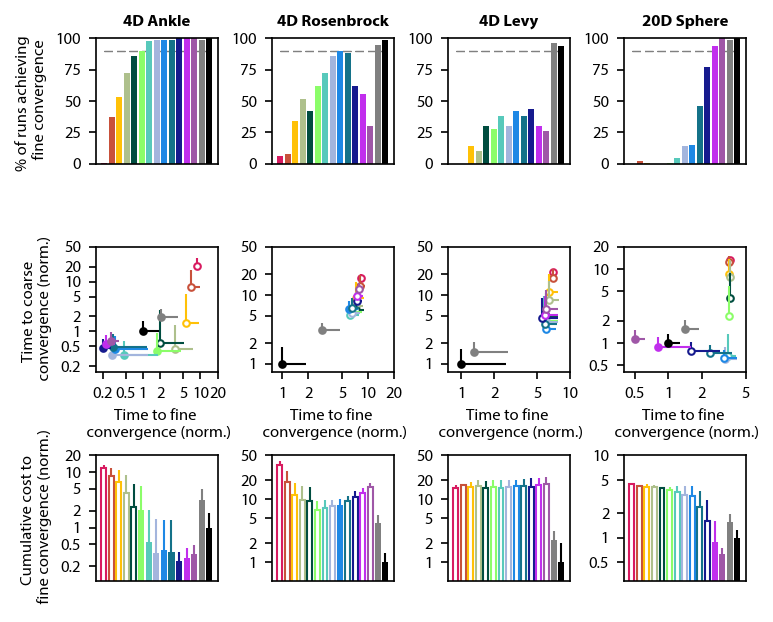

In [46]:
def plotBayesVsCMA_multiRun(bayes_files, cma_files):
	assert([len(bayes_files), len(cma_files)] == [4,4])

	for nLandscape in range(len(bayes_files)): # each file is a different landscape
		bayes_file = bayes_files[nLandscape]
		cma_file = cma_files[nLandscape]

		# settings
		plotStaticDurs = True
		minmaxscale = True
		CONVERG_RATE_THRESH = 0.90
		saveAsPDF = False
		figSaveLoc = 'figs/'
		scaleToASCMA = True

		plots = {
			'1': 0, # avg true cost of each gen mean +/- sd [line] (prev plot 2)
			'2': 1, # 3x4 multiplot 
		}

		# lookup table for nice functNames
		niceFunctNames = {
			'ankle' : '4D Ankle',
			'nParams20' : '20D Sphere',
			'nParams10' : '10D Sphere',
			'levy' : '4D Levy',
			'rosen_nDim' : '4D Rosenbrock'	
		}
		# lookup table for best CMA static duration [mins]
		bestCMAdurs = {
			'ankle': 4,
			'rosen_nDim': 3, 
			'levy': 2,
			'nParams20': 3.5 
		}
		# lookup table for adjusted thresholds
		adjConvergeThresh = {
			'ankle': .9,
			'rosen_nDim': .9, 
			'levy': .9,
			'nParams20': .9 
		}

		# declare variables 
		res = [None] 
		opt_params = [None] 
		functName = [None]
		dursToTest = [None]
		nDims = [None]
		pop_size = [None] 
		nVDs = [None] 
		nStaticDurs = [None]
		nDurs = [None]
		nExs = [None] 
		means_true = [None]
		values_true_avg = [None] 
		params_avg = [None] 
		sigmas_avg = [None] 
		timepoints_vd = [None]
		entire_costs = [None] 
		startup_cost = [None] 
		time_to_Xpct1 = [None]
		time_to_Xpct2 = [None]
		rate_to_Xpct1 = [None]
		rate_to_Xpct2 = [None]
		cost_to_Xpct1 = [None]
		cost_to_Xpct2 = [None]
		converged_def = [None]

		# read in cma data -  load and unpack data
		loc = 'G:\\My Drive\\Simulated HILO project\\Sim archive\sim_results\\'
		res = pickle.load(open(loc + cma_file + ' analysis.pickle', "rb"))
		opt_params = res['opt_params']						# nExamples, n_dim, functName, optimization_time, 
		functName = opt_params['functName']					# str
		dursToTest = res['dursToTest']						# int
		nVDs = res['nVDs']									# int
		nStaticDurs = res['nStaticDurs']					# int 
		nDurs = nVDs + nStaticDurs							# int
		means_true = res['means_true']						# shape(nExs, nGens, nDurs)
		nExs = np.shape(means_true)[0]
		values_true_avg = res['values_true_avg']			# shape(nConds, nDurs)
		params_avg = res['params_avg']						# shape(nDims, nConds, nDurs)
		nDims = np.shape(params_avg)[0]						# int
		pop_size = 4 + math.floor(3 * math.log(nDims))		# int
		sigmas_avg = res['sigmas_avg']						# shape(nExs, nGens, nDurs)
		timepoints_vd = res['timepoints_vd']				# list[nVDs][nEx][nConds]
		entire_costs = res['entire_costs']					# shape(nExs, nDurs)
		startup_cost = res['startup_cost']					# shape(nExs, nDurs)
		time_to_Xpct1 = res['time_to_Xpct1']				# shape(nExs, nDurs)
		time_to_Xpct2 = res['time_to_Xpct2']				# shape(nExs, nDurs)
		rate_to_Xpct1 = res['rate_to_Xpct1']				# shape(nDurs)
		rate_to_Xpct2 = res['rate_to_Xpct2']				# shape(nDurs)
		cost_to_Xpct1 = res['cost_to_Xpct1']				# shape(nExs, nDurs)
		cost_to_Xpct2 = res['cost_to_Xpct2']				# shape(nExs, nDurs)
		converged_def = res['converged_def']
		minCost = getTrueMinCost(functName, nDims)
		threshold_ys = (np.array([converged_def['within_x_pct1'], converged_def['within_x_pct2']]) + 1) * minCost

		# get bayes data
		loc = 'G:\\My Drive\\Simulated HILO project\\Sim archive\\bayesOpt results backup\\'
		res = pickle.load(open(loc + bayes_file + '.pickle', "rb"))
		bayes_res = getBayesOptMetrics(res, threshold_ys)
		maxTime = res['settings']['maxTime']

		# combine metrics - 'b' is bayesOpt, 'c' is CMA-ES
		time_to_Xpct1 = {						# shape(nExs, nDurs)
			'b': bayes_res['time_to_Xpct1'],
			'c': time_to_Xpct1}
		time_to_Xpct2 = {						# shape(nExs, nDurs)
			'b': bayes_res['time_to_Xpct2'],
			'c': time_to_Xpct2}
		rate_to_Xpct1 = {
			'b': bayes_res['rate_to_Xpct1'], 	# shape(nDurs)
			'c': rate_to_Xpct1}
		rate_to_Xpct2 = {
			'b': bayes_res['rate_to_Xpct2'], 	# shape(nDurs)
			'c': rate_to_Xpct2}
		cost_to_Xpct1 = {						# shape(nExs, nDurs)
			'b': bayes_res['cost_to_Xpct1'],
			'c': cost_to_Xpct1}
		cost_to_Xpct2 = {						# shape(nExs, nDurs)
			'b': bayes_res['cost_to_Xpct2'],
			'c': cost_to_Xpct2}

		# general plotting setup: get plot colors, names
		plotColors = Spectrum(nDurs-nVDs, mute_factor=0.9) 
		if 1:
			VDcolors = [(0,0,0), (0.25, 0.25, 0.25), (0.5, 0.5, 0.5), (0.75, 0.75, 0.75)]
		else:
			VDcolors = Spectrum(nRuns, mute_factor=0.6)
		dursToTestString = [str(x) for x in np.squeeze(dursToTest)]
		VDnames = ['AS']
		for i in range(nVDs):
			plotColors.append((VDcolors[i]))
			dursToTestString.append(VDnames[i])
		nDursToPlot = list(range(nDurs))
		bestCMAStaticColor = (0.5, 0.5, 0.5)

		# identify which CMA static dur to plot
		idx_of_best_cma_dur = np.argwhere(dursToTest == bestCMAdurs[functName])[0][0]

		# create figure specs
		axisLabelFontSz = 8
		axisTickFontSz = 8
		legendTitleFontSz = 8
		legendLabelsFontSz = 6
		subTitleFontSz = 8
		scale = 1 
		nCols = 2
		nRows = 2
		figWidth_in = 2.1
		figHeight_in = 1.8
		figPad = .25
		figLineWidth = 1
		figMarkerSize = 10
		fig_height_scale = 0.85

		# figure: avg true cost of each gen mean 
		if plots['1']:
			plt.figure(num=1, figsize=(figWidth_in*nCols*scale,figHeight_in*nRows*scale*fig_height_scale), dpi=150)
			plt.subplot(2,2, nLandscape+1) 
			
			minCost = getTrueMinCost(functName, nDims)
			threshold_ys = (np.array([converged_def['within_x_pct1'], converged_def['within_x_pct2']]) + 1) * minCost
			optimization_time = opt_params['optimization_time']
			if minmaxscale:
				avg_initial_mean_cost = np.average(means_true[:, 0, :])

			# plot cma (only AS-CMA and best duration)
			for nDur in range(nDurs):
				if nDur < nDurs-nVDs and plotStaticDurs:
					dur = dursToTest[nDur][0]
					y_orig = np.nanmean(means_true,axis=0)[:,nDur]
					y = y_orig[y_orig != 0]
					y = np.insert(y, 0, y[0])
					ystd = np.nanstd(means_true, axis=0)[:,nDur] 
					ystd = ystd[y_orig != 0]
					ystd = np.insert(ystd, 0, ystd[0])
					x = dur * pop_size * np.arange(1,np.size(y))
					x = np.insert(x,0, 0)
				elif nDur >= nDurs-nVDs: 
					x = np.linspace(0, optimization_time, optimization_time)
					y = np.zeros((nExs, np.size(x)))
					for nEx in range(nExs):
						x_orig = timepoints_vd[nDur-(nDurs-nVDs)][nEx][pop_size-1::pop_size]
						y_orig = means_true[nEx, :, nDur]
						y_orig = y_orig[y_orig != 0]
						y[nEx,:] = np.interp(x, x_orig, y_orig)
					ystd = np.std(y, axis=0)
					y = np.mean(y, axis=0)

				if minmaxscale: 
					y = minMaxScaler(functName, y, nDims, avg_initial_mean_cost)
					
					
				if (nDur < nDurs-nVDs and plotStaticDurs and nDur == idx_of_best_cma_dur) or (nDur >= nDurs-nVDs):
					if nDur == idx_of_best_cma_dur:
						plt.plot(x, y, color=bestCMAStaticColor, label=dursToTestString[nDur], zorder = nDur*100, linewidth=figLineWidth*1.5)
					else:
						plt.plot(x, y, color=plotColors[nDur], label=dursToTestString[nDur], zorder = nDur*100, linewidth=figLineWidth*1.5)

			if minmaxscale:
				threshold_ys = minMaxScaler(functName, threshold_ys, nDims, avg_initial_mean_cost)
			plt.plot(np.array([x[0], x[-1]]), np.array([threshold_ys[0],threshold_ys[0]]), color=[0.5,0.5,0.5], alpha=0.5, linestyle='--', linewidth=figLineWidth)
			plt.plot(np.array([x[0], x[-1]]), np.array([threshold_ys[1],threshold_ys[1]]), color=[0.5,0.5,0.5], alpha=0.5, linestyle='--', linewidth=figLineWidth)

			# plot bayesOpt
			for nDur in range(nDurs-1): # minus one b/c no as-cma
				dur = dursToTest[nDur]

				x = np.arange(start=dur, stop=maxTime+dur, step = dur) 
				y = res['costOfEstBest'][nDur, :, 0:np.size(x)]    # shape [nExs, nConditions]
				y_mean = np.mean(y, axis=0)

				y_mean = np.insert(y_mean, 0, y_mean[0])
				x = np.insert(x, 0, 0)

				if minmaxscale: 
					y_mean = minMaxScaler(functName, y_mean, nDims, avg_initial_mean_cost)

				plt.plot(x, y_mean, color=plotColors[nDur], linestyle = '-', zorder=nDur*2+1, linewidth=figLineWidth)

			plt.title(niceFunctNames[functName], fontsize=subTitleFontSz, fontweight='bold')
			
			plt.xscale("log")
			plt.yscale("log")
			plt.xlim([4, optimization_time])
			ax = plt.gca()
			ax.tick_params(axis='x', which='minor', bottom=False)
			plt.minorticks_off()
			formatter = ScalarFormatter()
			ax.xaxis.set_major_formatter(formatter)
			ax.xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
			x_tick_positions = [10, 100, 1000]
			ax.xaxis.set_major_locator(FixedLocator(x_tick_positions))     
			y_tick_positions = [0.0001, 0.001, 0.01, 0.1, 1]
			ax.yaxis.set_major_locator(FixedLocator(y_tick_positions))   
			plt.tick_params(axis='both', which='major', labelsize=axisTickFontSz)
			
			if nLandscape in [0,2]:
				plt.ylabel('True cost (normalized)', fontsize=axisLabelFontSz)
				plt.ylim(bottom=1E-3)
			if nLandscape in [2,3]:
				plt.xlabel('Optimization time (mins)', fontsize=axisLabelFontSz)				

			plt.tight_layout(pad=figPad)
			plt.subplot(nRows, nCols, 2)

			if saveAsPDF:
				plt.savefig(figSaveLoc+'plot1BO_costVsTime.pdf', bbox_inches='tight')

		# figure: 3x4 multiplot
		if plots['2']:
			plt.figure(num=2, figsize=(5.04,3.96), dpi=150)

			# ~ convergence rate ~
			if 1:
				plt.subplot(3, 4, nLandscape+1) 
				width = 0.8
				if 1: 
					rate = rate_to_Xpct1
					rate_name = '(within 5% of min)'
				else: 
					rate = rate_to_Xpct2
					rate_name = '(within 20% of min)'
				
				counter = 0
				labels = []
				for nDur in range(nDurs):
					# note that Xpct 1 and 2 are fine and coarse, respectively
					if nDur < nDurs-1:
						plt.bar(counter, np.mean(rate['b'][nDur])*100, width=width, color=plotColors[nDur], zorder = 2)
						labels.append(str(dursToTestString[nDur]))
					counter += 1
					plt.hlines(adjConvergeThresh[functName]*100, 0, np.max(nDursToPlot)+1, color=[0.5,0.5,0.5], alpha=0.5, linestyle=(0, (8,4)), linewidth=figLineWidth*.5, zorder=1)


				# plot AS and best static CMA
				for nDur in range(nDurs):
					if nDur == idx_of_best_cma_dur: 
						plt.bar(counter-1, np.mean(rate['c'][nDur])*100, width=width, color=bestCMAStaticColor, zorder=2)
						labels.append('CMA '+str(dursToTestString[nDur]))
					elif nDur == nDurs-1: 
						plt.bar(counter, np.mean(rate['c'][nDur])*100, width=width, color='k', zorder=2)
						labels.append(str(dursToTestString[nDur]))


				# plot housekeeping
				plt.title(niceFunctNames[functName], fontsize=subTitleFontSz, fontweight='bold')
				plt.tick_params(axis='both', which='major', labelsize=axisTickFontSz)
				plt.ylim(0,100)
				y_tick_positions = [0, 25, 50, 75, 100]
				ax = plt.gca()
				ax.yaxis.set_major_locator(FixedLocator(y_tick_positions)) 
				plt.xticks([])
				if nLandscape == 0:
					plt.ylabel('% of runs achieving \n fine convergence', fontsize=axisLabelFontSz)

			# ~ time to converge ~
			if 1: 
				ax = plt.subplot(3, 4, nLandscape+5)

				opts = ['b', 'c']			
				for opt in opts:
					# only plot a dur if it acheived xpct1 and xpct2 more than a certain rate
					for nDur in range(nDurs):
						if not (opt=='b' and nDur>12):
							achiev_rate_xpct1 = rate_to_Xpct1[opt][nDur]
							achiev_rate_xpct2 = rate_to_Xpct2[opt][nDur]
							x = np.nanmean(time_to_Xpct1[opt][:, nDur])
							y = np.nanmean(time_to_Xpct2[opt][:, nDur])
							xstd = np.nanstd(time_to_Xpct1[opt][:, nDur])
							ystd = np.nanstd(time_to_Xpct2[opt][:, nDur])
							z = nDur 
							if scaleToASCMA:
								y /= np.nanmean(time_to_Xpct2['c'][:, -1])
								ystd /= np.nanmean(time_to_Xpct2['c'][:, -1])
								x /= np.nanmean(time_to_Xpct1['c'][:, -1])
								xstd /= np.nanmean(time_to_Xpct1['c'][:, -1])
							# plot BO (sufficient convergence)
							if achiev_rate_xpct1 > adjConvergeThresh[functName] and achiev_rate_xpct2 > adjConvergeThresh[functName] and opt=='b':
								plt.scatter(x, y, color=plotColors[nDur], zorder = z+1, s=figMarkerSize)
								# plt.errorbar(x,y, xerr = xstd, yerr = ystd, ecolor=plotColors[nDur], fmt = 'none', zorder = z, linewidth=figLineWidth)
								plt.errorbar(x+xstd/2,y, xerr = xstd/2, ecolor=plotColors[nDur], fmt = 'none', zorder = z+1, linewidth=figLineWidth)
								plt.errorbar(x,y+ystd/2, yerr = ystd/2, ecolor=plotColors[nDur], fmt = 'none', zorder = z+1, linewidth=figLineWidth)
							# plot BO (poor convergence)
							elif opt=='b': 
								plt.errorbar(x+xstd/2,y, xerr = xstd/2, ecolor=plotColors[nDur], fmt = 'none', zorder = z, linewidth=figLineWidth)
								plt.errorbar(x,y+ystd/2, yerr = ystd/2, ecolor=plotColors[nDur], fmt = 'none', zorder = z, linewidth=figLineWidth)
								plt.scatter(x, y, edgecolor=plotColors[nDur], facecolor=(1,1,1), zorder = z, s=figMarkerSize, linewidth=figLineWidth)

							# plot best ASCMA result
							elif opt=='c' and nDur == idx_of_best_cma_dur:
								plt.errorbar(x+xstd/2,y, xerr = xstd/2, ecolor=bestCMAStaticColor, fmt = 'none', zorder = z+2, linewidth=figLineWidth)
								plt.errorbar(x,y+ystd/2, yerr = ystd/2, ecolor=bestCMAStaticColor, fmt = 'none', zorder = z+2, linewidth=figLineWidth)
								plt.scatter(x, y, color=bestCMAStaticColor, zorder = z+2,  s=figMarkerSize)
							# plot best ASCMA result
							elif opt=='c' and nDur == nDurs-1:
								plt.errorbar(x+xstd/2,y, xerr = xstd/2, ecolor=plotColors[nDur], fmt = 'none', zorder = z+2, linewidth=figLineWidth)
								plt.errorbar(x,y+ystd/2, yerr = ystd/2, ecolor=plotColors[nDur], fmt = 'none', zorder = z+2, linewidth=figLineWidth)
								plt.scatter(x, y, color='k', zorder = z+2,  s=figMarkerSize)

				
				# plot housekeeping
				plt.tick_params(axis='both', which='major', labelsize=axisTickFontSz)
				if nLandscape == 0:
					plt.ylabel('Time to coarse \n convergence (norm.)', fontsize=axisLabelFontSz)
				if nLandscape in [0,1,2,3]:
					plt.xlabel('Time to fine \n convergence (norm.)', fontsize=axisLabelFontSz); 
				if 0: # regular
					plt.ylim(bottom=0)
					plt.xlim(left=0)
					if scaleToASCMA:
						y_min, y_max = ax.get_ylim()  # Get the current y-axis limits
						ax.set_yticks(np.arange(np.floor(y_min), np.ceil(y_max) + 1, 1))  # Set y-ticks with step of 1
						x_min, x_max = ax.get_xlim()  # Get the current y-axis limits
						ax.set_xticks(np.arange(np.floor(x_min), np.ceil(x_max) + 1, 1))  # Set y-ticks with step of 1
				else: # log
					plt.xscale('log')
					plt.yscale('log')
					lowerLims = [.15, .75, .75, .4]
					plt.xlim(left=lowerLims[nLandscape])
					plt.ylim(bottom=lowerLims[nLandscape])
					ax = plt.gca()
					ax.tick_params(axis='x', which='minor', bottom=False)
					plt.minorticks_off()
					formatter = ScalarFormatter()
					ax.xaxis.set_major_formatter(formatter)
					ax.yaxis.set_major_formatter(FuncFormatter(custom_formatter))
					ax.xaxis.set_major_formatter(FuncFormatter(custom_formatter))
					x_tick_positions = [.1, .2, .5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
					ax.xaxis.set_major_locator(FixedLocator(x_tick_positions))     
					y_tick_positions = [.1, .2, .5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
					ax.yaxis.set_major_locator(FixedLocator(y_tick_positions))   
					plt.tick_params(axis='both', which='major', labelsize=axisTickFontSz)
					y_min, y_max = ax.get_ylim()
					plt.ylim(top = y_tick_positions[np.argwhere(y_tick_positions > y_max)[0][0]])
					x_min, x_max = ax.get_xlim()
					plt.xlim(right = x_tick_positions[np.argwhere(x_tick_positions > x_max)[0][0]])

			# ~ cost to converge ~
			if 1: 
				ax = plt.subplot(3, 4, nLandscape+9) 
				
				counter = 0
				width = .8
				if scaleToASCMA:
					scaler = cost_to_Xpct1['c'][:,-1]
				else:
					scaler = 1
				# plot BO
				for nDur in range(nDurs):
					if nDur < nDurs-1:
						mean = np.mean(cost_to_Xpct1['b'][:,nDur])/np.mean(scaler)
						sd = np.std(cost_to_Xpct1['b'][:,nDur])/np.mean(scaler)
						c = plotColors[nDur]
						# if adequate convergence rate, fill bar with color
						if rate_to_Xpct1['b'][nDur] >= adjConvergeThresh[functName]:
							plt.errorbar(counter, mean, xerr = 0, yerr=sd, ecolor=c, alpha=1, fmt = 'none', zorder=1, linewidth=figLineWidth)
							plt.bar(counter, mean, color=c, alpha=1, width=width, zorder=2)
						# if poor convergence rate, fill bar with white
						else:
							plt.errorbar(counter, mean, xerr = 0, yerr=sd, ecolor=c, alpha=1, fmt = 'none', zorder=1, linewidth=figLineWidth)
							plt.bar(counter, mean, color=(1,1,1), alpha=1, edgecolor = c, width=width-.15, zorder=2, linewidth=figLineWidth)
						counter += 1
				
				# plot AS and best static CMA
				for nDur in range(nDurs):
					if nDur == idx_of_best_cma_dur: 
						plt.bar(counter, np.mean(cost_to_Xpct1['c'][:,nDur]/scaler), color=bestCMAStaticColor, alpha=1, width=width)
						plt.errorbar(counter, np.mean(cost_to_Xpct1['c'][:,nDur]/scaler), xerr = 0, yerr= np.std(cost_to_Xpct1['c'][:,nDur])/np.mean(scaler), ecolor=bestCMAStaticColor, alpha=1, fmt = 'none', linewidth=figLineWidth)
						counter += 1
					elif nDur == nDurs-1: 
						plt.bar(counter, np.mean(cost_to_Xpct1['c'][:,nDur]/scaler), color='k', alpha=1, width=width)
						plt.errorbar(counter, np.mean(cost_to_Xpct1['c'][:,nDur]/scaler), xerr = 0, yerr= np.std(cost_to_Xpct1['c'][:,nDur])/np.mean(scaler), ecolor='k', alpha=1, fmt = 'none', linewidth=figLineWidth)

				# plot housekeeping
				plt.xticks([])
				if nLandscape in [0]:
					plt.ylabel('Cumulative cost to \n fine convergence (norm.)', fontsize=axisLabelFontSz)
				plt.tick_params(axis='both', which='major', labelsize=axisTickFontSz)
				if 0: 
					plt.ylim(bottom=0)
					y_min, y_max = ax.get_ylim()  # Get the current y-axis limits
					y_tick_step = 1 if np.ceil(y_max)<15 else 4
					ax.set_yticks(np.arange(np.floor(y_min), np.ceil(y_max) + 1, y_tick_step))  # Set y-ticks with step of 1
					
				else:	
					plt.yscale('log')
					bottoms = [.11, .51, .51, .3]
					plt.ylim(bottom=bottoms[nLandscape])
					ax = plt.gca()
					plt.minorticks_off()
					formatter = ScalarFormatter()
					ax.yaxis.set_major_formatter(FuncFormatter(custom_formatter))
					y_tick_positions = [.1, .2, .5, 1, 2, 5, 10, 20, 50, 100]
					ax.yaxis.set_major_locator(FixedLocator(y_tick_positions))   
					y_min, y_max = ax.get_ylim()
					plt.ylim(top = y_tick_positions[np.argwhere(y_tick_positions > y_max)[0][0]])

			plt.tight_layout(pad=figPad+.25)
			if saveAsPDF:
				plt.savefig(figSaveLoc+'plot7BO_allMetrics.pdf', bbox_inches='tight')
			
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
bayes_file_ankle='BO_f=ankle,t=1000,n=100'
cma_file_ankle= '2024-09-17 1' 
bayes_file_levy='BO_f=levy,t=2000,n=50'
cma_file_levy='2024-09-17 3' 
bayes_file_rosen='BO_f=rosen_nDim,t=2000,n=50'
cma_file_rosen='2024-09-17 2'
bayes_file_nParams20='BO_f=nParams20,t=2000,n=100'
cma_file_nParams20='2024-09-17 5'

bayes_files = [bayes_file_ankle, bayes_file_rosen, bayes_file_levy, bayes_file_nParams20]
cma_files = [cma_file_ankle, cma_file_rosen, cma_file_levy, cma_file_nParams20]
plotBayesVsCMA_multiRun(bayes_files, cma_files)